In [52]:
import pandas as pd 
import numpy as np
from pandas_datareader import data, wb
import pandas_datareader as pdr
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import datetime
import math
import stock_cache # local module

pd.set_option('display.expand_frame_repr', False)
fdr.__version__

MOMENTUM_DAYS = 180 # 6개월

now = datetime.datetime.now()
start_time = datetime.datetime(2020, 1, 1, 9, 0, 0)
end_time = datetime.datetime(2021, 9, 5, 9, 0, 0)
#EST = datetime.timezone(datetime.timedelta(hours=-5))
#start_time = datetime.datetime(2020, 1, 1, 9, 0, 0, tzinfo=EST)
#start_time = datetime.datetime.strptime("20200101", "%Y%m%d")
#end_time = datetime.datetime.strptime("20210101", "%Y%m%d")
#start_time = now - datetime.timedelta(weeks=52) # 1년 전으로 start 설정
#end_time = now - datetime.timedelta(weeks=4) # 1달 전으로 end 설정

# 테스트 코드

## Dictionary append

In [214]:
ticker_dict = { }
ticker_dict["005930.KS"] = { "code": "005930.KS", "name": "Samsung"}
for k, v in ticker_dict.items():
    k = code
    print(k, v)

005930.KS {'code': '005930.KS', 'name': 'Samsung'}


## DataFrame append

In [215]:
dates = pd.date_range("20130101", periods=6)
print(type(dates[0]))
df = pd.DataFrame(columns=['A', 'B'])
for i in range(5):
    df = df.append(pd.Series({'A':i, 'B':i}, index=df.columns, name=dates[i]))
df.head()

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,A,B
2013-01-01,0,0
2013-01-02,1,1
2013-01-03,2,2
2013-01-04,3,3
2013-01-05,4,4


# 종목 정보 가져오기

In [41]:
# DataFrame
#def get_rate_of_return(x):
#    return round((x.iloc[-1]-x.iloc[0]),2)

def add_relative_value(ticker_data, src_name):
    # 100기준 종가 컬럼 추가
    ticker_data['relative_value'] = ticker_data[src_name] / ticker_data[src_name].iloc[0]*100
    
def get_ticker_data(code, start_time, end_time, use_fdr=False):
    global MOMENTUM_DAYS
    prev_start_time = start_time - datetime.timedelta(days=MOMENTUM_DAYS)
    prev_end_time = start_time - datetime.timedelta(days=1)
    
    # 이전 180일 데이터 조회, 타겟 기간 데이터 조회
    prev_data = stock_cache.get_stock_data_second_half(code, prev_start_time, prev_end_time, use_fdr)
    prev_len = len(prev_data)
    if (prev_len <= 0): # TODO 0보다는 크나 갯수가 충분하지 않으면?
        print("get_ticker_data(): ticker_data not enough", "prev_len)=", prev_len)
        return pd.DataFrame()
    ticker_data = stock_cache.get_stock_data(code, start_time, end_time, use_fdr)
    ticker_len = len(ticker_data)
    if (ticker_len <= 0): # TODO 0보다는 크나 갯수가 충분하지 않으면?
        print("get_ticker_data(): ticker_data not enough", "ticker_len=", ticker_len)
        return pd.DataFrame()
    total_data = pd.concat([prev_data, ticker_data])

    # 1일전 종가 컬럼 추가, 180일전 종가/수익률 컬럼 추가
    start_loc = len(prev_data)-1
    prev_data01 = total_data[start_loc:start_loc+len(ticker_data)]
    prev_data180 = total_data[:len(ticker_data)]
    ticker_data['prev_close01'] = prev_data01['Close'].values
    ticker_data['prev_close180'] = prev_data180['Close'].values
    prev_rate180 = (ticker_data['Close'] - ticker_data['prev_close180'])/ticker_data['prev_close180']*100
    ticker_data['prev_rate180'] = prev_rate180.values
    
    # 이동평균 컬럼 추가
    ma5 = total_data['Close'].rolling(window=5).mean()
    ma25 = total_data['Close'].rolling(window=25).mean()
    ma50 = total_data['Close'].rolling(window=50).mean()
    ma100 = total_data['Close'].rolling(window=100).mean()
    ticker_data['ma5'] = ma5[prev_len:]
    ticker_data['ma25'] = ma25[prev_len:]
    ticker_data['ma50'] = ma50[prev_len:]
    ticker_data['ma100'] = ma100[prev_len:]
    
    # ATR(Average Trace Range) 추가
    tr = total_data['High'] - total_data['Low']
    ticker_data['tr'] = tr[prev_len:]
    atr20 = tr.rolling(window=20).mean()
    ticker_data['atr20'] = atr20[prev_len:]
    
    # ATA(Average Trading Amount-총거래액) 추가
    ta = total_data['Close'] * total_data['Volume']
    ticker_data['ta'] = ta[prev_len:]
    ata20 = ta.rolling(window=20).mean()
    ticker_data['ata20'] = ata20[prev_len:]
    
    return ticker_data

# cache 이용하지 않고 직접 호출(미사용이며 참고용)
def get_ticker_data_direct(code, start_time, end_time, use_fdr=False):
    global MOMENTUM_DAYS
    prev_start_time = start_time - datetime.timedelta(days=MOMENTUM_DAYS)
    prev_end_time = start_time - datetime.timedelta(days=1)
    
    if (use_fdr):
        prev_data = fdr.DataReader(code, prev_start_time, prev_end_time)
        ticker_data = fdr.DataReader(code, start_time, end_time)
        total_data = pd.concat([prev_data, ticker_data])
    else:
        prev_data = pdr.data.get_data_yahoo(code, prev_start_time, prev_end_time)
        ticker_data = pdr.data.get_data_yahoo(code, start_time, end_time)
        total_data = pd.concat([prev_data, ticker_data])

    # 180일전 종가 컬럼, 180일전 대비 수익율 컬럼 추가
    prev_close180 = total_data[:len(ticker_data)]
    ticker_data['prev_close180'] = prev_close180['Close'].values
    prev_rate180 = (ticker_data['Close'] - ticker_data['prev_close180'])/ticker_data['prev_close180']*100
    ticker_data['prev_rate180'] = prev_rate180.values
    
    # 이동평균 컬럼 추가
    ma5 = total_data['Close'].rolling(window=5).mean()
    ma25 = total_data['Close'].rolling(window=25).mean()
    ma50 = total_data['Close'].rolling(window=50).mean()
    ma100 = total_data['Close'].rolling(window=100).mean()
    ticker_data['ma5'] = ma5[len(prev_data):]
    ticker_data['ma25'] = ma25[len(prev_data):]
    ticker_data['ma50'] = ma50[len(prev_data):]
    ticker_data['ma100'] = ma100[len(prev_data):]
    return ticker_data

# 차트
def show_chart():
    fig = plt.figure(figsize=(10,5))
    fig.tight_layout()
    subplot = fig.add_subplot(1,1,1)

    for k, v in std_dict.items():
        name = v['stock_name']
        ticker_data = v['data']
        subplot.plot(ticker_data['relative_value'], label=name)
        subplot.legend()

    for k, v in ticker_dict.items():
        if (k in ["005930.KS"]):
            name = v['stock_name']
            ticker_data = v['data']
            subplot.plot(ticker_data['relative_value'], label=name)
            subplot.legend()

    name = 'LTHM'
    ticker_data = system.data
    subplot.plot(ticker_data['relative_value'], label=name)
    subplot.legend()
    #plt.show()
    return subplot

In [54]:
def load_std_dict(std_dict, year):
    start_time = datetime.datetime(year, 1, 1, 9, 0, 0)
    end_time = datetime.datetime(year, 12, 31, 9, 0, 0)
    for k, v in std_dict.items():
        code = k
        prev_data = std_dict[code]['data']
        target_data = get_ticker_data(code, start_time, end_time, use_fdr=True)
        total_data = pd.concat([prev_data, target_data])
        
        # 100기준 종가 컬럼 추가
        add_relative_value(total_data, 'Close')
        std_dict[code]['data'] = total_data

def load_ticker_dict(ticker_dict, year):
    start_time = datetime.datetime(year, 1, 1, 9, 0, 0)
    end_time = datetime.datetime(year, 12, 31, 9, 0, 0)    
    for k in list(ticker_dict.keys()): # list 없으면 에러 발생 - dictionary changed size during iteration
        code = k
        stock_name = ticker_dict[code]['stock_name']

        prev_data = ticker_dict[code]['data']
        target_data = get_ticker_data(code, start_time, end_time)
        total_data = pd.concat([prev_data, target_data])
                
        # total_data 갯수 없는 경우 삭제 (초기 데이터 없는 경우 제외됨)
        if (len(total_data) <= 0):
            print("ticker_data not enough, remove:", "code=", code, "stock_name=", stock_name)
            del ticker_dict[code]
            continue
        
        # 100기준 종가 컬럼 추가
        add_relative_value(total_data, 'Close')
        ticker_dict[code]['data'] = total_data

def verify_ticker_data(ticker_data):
    # 전일 대비 30% 이상 상승/하락시 에러
    result_filter = abs((ticker_data['Close'] - ticker_data['prev_close01']) / ticker_data['prev_close01'] * 100) > 30
    result_data = ticker_data[result_filter]
    #result_data = ticker_data[abs((ticker_data['Close'] - ticker_data['prev_close01']) / ticker_data['prev_close01'] * 100) > 30]

    if (len(result_data) > 0):
        print(f"verify_ticker_data(): abnormal data exist")
        print(result_data.head())
        return False
    return True

def verify_ticker_dict():
    for k in list(ticker_dict.keys()):
        code = k
        stock_name = ticker_dict[code]['stock_name']
        ticker_data = ticker_dict[code]['data']
        if (not verify_ticker_data(ticker_data)):
            print(f"verify_ticker_dict(): verify_ticker_data failed: code={code} stock_name={stock_name}")


In [78]:
std_dict = { 
    "KS11": { "stock_name": "KOSPI", "data": pd.DataFrame() },
    "KS200": { "stock_name": "KOSPI200", "data": pd.DataFrame() }
}
system_dict = {
}

load_std_dict(std_dict, 2020)
load_std_dict(std_dict, 2021)

In [79]:
ticker_dict_10 = {
    "005930.KS": { "stock_name": "Samsung", "data": pd.DataFrame() },
    "000660.KS": { "stock_name": "SK Hynix", "data": pd.DataFrame() },
    "051910.KS": { "stock_name": "LG화학", "data": pd.DataFrame() },
    "068270.KS": { "stock_name": "셀트리온", "data": pd.DataFrame() },
    "035420.KS": { "stock_name": "Naver", "data": pd.DataFrame() },
    "006400.KS": { "stock_name": "Samsung SDI", "data": pd.DataFrame() },
    "005380.KS": { "stock_name": "Hyundai", "data": pd.DataFrame() },
    "035720.KS": { "stock_name": "Kakao", "data": pd.DataFrame() },
    "036570.KS": { "stock_name": "NCsoft", "data": pd.DataFrame() },
    "051900.KS": { "stock_name": "LG생활건강", "data": pd.DataFrame() }
}
#ticker_dict = ticker_dict_10.copy()
#del ticker_dict['005930.KS']
#ticker_dict = ticker_dict_10

ticker_exclude_list = []
#ticker_exclude_list = ["105560.KS"] # KB금융 - 2020-04-02 부터 3만원대 -> 3백만원대 -> 파라미터로 전달하지 않더라도 verify 코드에서 걸러냄
ticker_dict = stock_cache.get_stock_listing_dict(1000, ticker_exclude_list) # 갯수 만큼 KOSPI 종목 리스트 가져오기
print("ticker_dict len =", len(ticker_dict))

load_ticker_dict(ticker_dict, 2020)
load_ticker_dict(ticker_dict, 2021)

ticker_dict len = 817
get_ticker_data(): ticker_data not enough prev_len)= 0
ticker_data not enough, remove: code= 375500.KS stock_name= DL이앤씨
get_ticker_data(): ticker_data not enough prev_len)= 0
ticker_data not enough, remove: code= 365550.KS stock_name= ESR켄달스퀘어리츠
get_ticker_data(): ticker_data not enough prev_len)= 0
ticker_data not enough, remove: code= 383220.KS stock_name= F&F
get_ticker_data(): ticker_data not enough prev_len)= 0
ticker_data not enough, remove: code= 344820.KS stock_name= KCC글라스
get_ticker_data(): ticker_data not enough prev_len)= 0
ticker_data not enough, remove: code= 383800.KS stock_name= LX홀딩스
get_ticker_data(): ticker_data not enough prev_len)= 0
ticker_data not enough, remove: code= 302440.KS stock_name= SK바이오사이언스
get_ticker_data(): ticker_data not enough prev_len)= 0
ticker_data not enough, remove: code= 326030.KS stock_name= SK바이오팜
get_ticker_data(): ticker_data not enough prev_len)= 0
ticker_data not enough, remove: code= 361610.KS stock_name= SK아이이테크

In [53]:
verify_ticker_dict()

verify_ticker_data(): 
                     High            Low           Open          Close   Volume     Adj Close   prev_close01  prev_close180  prev_rate180            ma5           ma25           ma50          ma100          tr        atr20            ta         ata20  relative_value
2020-02-18  181648.546875  179845.578125  180972.421875  180972.421875    40311  178137.90625   80800.000000   92100.000000     96.495572  102134.484375   87686.896875   87869.448438   91597.724219  1802.96875  2280.148438  7.295179e+09  9.773235e+09      206.118932
2021-01-25   79700.000000   72500.000000   75000.000000   74600.000000  3101504   74600.00000  187057.421875  196297.609375    -61.996481  164565.937500  186020.817500  186687.867188  186730.664375  7200.00000  1858.713281  2.313722e+11  3.305425e+10       84.965831
verify_ticker_dict(): verify_ticker_data failed: code=000210.KS stock_name=DL
verify_ticker_data(): 
               High      Low     Open    Close   Volume  Adj Close  prev_cl

verify_ticker_data(): 
                    High           Low          Open         Close    Volume     Adj Close  prev_close01  prev_close180  prev_rate180           ma5         ma25         ma50        ma100           tr        atr20            ta         ata20  relative_value
2020-08-03  19932.003906  16123.655273  16519.328125  19932.003906  34615387  19749.142578  15332.310547    4693.665527    324.657526  14095.833789  11058.25582  9675.380371  7520.597229  3808.348633  1273.076465  6.899540e+11  1.248623e+11      289.096133
verify_ticker_dict(): verify_ticker_data failed: code=192650.KS stock_name=드림텍
verify_ticker_data(): 
             High    Low   Open  Close  Volume  Adj Close  prev_close01  prev_close180  prev_rate180      ma5     ma25     ma50    ma100    tr  atr20          ta         ata20  relative_value
2021-06-29  23900  21550  22550  22500  333264      22500         17200           7180    213.370474  17240.0  16212.0  14825.4  11871.9  2350  862.5  7498440000  2.8551

verify_ticker_data(): 
              High     Low    Open   Close    Volume  Adj Close  prev_close01  prev_close180  prev_rate180          ma5         ma25         ma50        ma100     tr       atr20            ta         ata20  relative_value
2020-03-20  1370.0  1270.0  1300.0  1360.0   2605310     1360.0    926.862000         4240.0    -67.924528  1184.380383  1762.512468  2391.756234  2707.228117  100.0  127.917963  3.543222e+09  3.580062e+09       49.908257
2020-04-21  2885.0  2130.0  2625.0  2525.0  22973529     2525.0   1864.589966         3520.0    -28.267045  1944.534009  1474.295239  1766.685615  2319.992808  755.0  192.530057  5.800816e+10  1.989083e+10       92.660550
verify_ticker_dict(): verify_ticker_data failed: code=005110.KS stock_name=한창
verify_ticker_data(): 
                    High      Low          Open         Close   Volume     Adj Close  prev_close01  prev_close180  prev_rate180           ma5          ma25          ma50         ma100            tr        atr20

In [56]:
std_data = std_dict['KS200']['data']
std_data.head()

,Close,Open,High,Low,Volume,Change,prev_close01,prev_close180,prev_rate180,relative_value,ma5,ma25,ma50,ma100,tr,atr20,ta,ata20
2020-01-02,290.35,294.19,294.57,289.96,66160000.0,-0.0116,295.20,272.37,6.601314,100.000000,293.476,285.2296,282.9260,273.8723,4.61,2.8280,1.920956e+10,2.157121e+10
2020-01-03,290.74,293.10,294.88,289.04,79770000.0,0.0013,290.35,274.54,5.900779,100.134321,292.650,285.5716,283.2650,274.2078,5.84,2.9965,2.319233e+10,2.180681e+10
2020-01-06,288.43,287.73,289.41,287.49,69960000.0,-0.0079,290.74,274.35,5.132130,99.338729,291.756,285.8356,283.4854,274.5580,1.92,2.9550,2.017856e+10,2.188664e+10
2020-01-07,291.23,290.01,292.26,289.64,65350000.0,0.0097,288.43,268.55,8.445355,100.303082,291.190,286.1708,283.7854,274.9503,2.62,2.9785,1.903188e+10,2.171531e+10
2020-01-08,289.42,288.94,291.01,287.30,124530000.0,-0.0062,291.23,267.72,8.105483,99.679697,290.034,286.4984,284.0398,275.3205,3.71,2.9590,3.604147e+10,2.260853e+10


In [57]:
std_data.loc['2021-06-23']

Close             4.367300e+02
Open              4.346500e+02
High              4.373700e+02
Low               4.346200e+02
Volume            3.720800e+08
Change            5.300000e-03
prev_close01      4.344200e+02
prev_close180     3.721800e+02
prev_rate180      1.734376e+01
relative_value    1.504150e+02
ma5               4.344720e+02
ma25              4.299496e+02
ma50              4.285250e+02
ma100             4.226915e+02
tr                2.750000e+00
atr20             3.826500e+00
ta                1.624985e+11
ata20             1.228839e+11
Name: 2021-06-23 00:00:00, dtype: float64

In [49]:
ticker_data = ticker_dict['005930.KS']['data']
#ticker_data = ticker_dict['365550.KS']['data']
ticker_data.head()

,High,Low,Open,Close,Volume,Adj Close,prev_close01,prev_close180,prev_rate180,ma5,ma25,ma50,ma100,tr,atr20,ta,ata20,relative_value
2020-01-02,56000,55000,55500,55200,12993228,52305.605469,56500,46250,19.351351,55520.0,53078.0,52417.0,49350.0,1000,985.0,717226185600,7.223392e+11,100.000000
2020-01-03,56600,54900,56000,55500,15422255,52589.875000,55200,45400,22.246696,55520.0,53226.0,52529.0,49455.5,1700,1025.0,855935152500,7.175652e+11,100.543478
2020-01-06,55600,54600,54900,55500,10278951,52589.875000,55500,46000,20.652174,55620.0,53374.0,52633.0,49571.0,1000,1035.0,570481780500,7.160001e+11,100.543478
2020-01-07,56400,55600,55700,55800,10009778,52874.144531,55500,45650,22.234392,55700.0,53518.0,52725.0,49694.0,800,1032.5,558545612400,7.111753e+11,101.086957
2020-01-08,57400,55900,56200,56800,23501171,53821.703125,55800,44400,27.927928,55760.0,53738.0,52837.0,49830.0,1500,1062.5,1334866512800,7.520556e+11,102.898551


In [51]:
ticker_data.loc['2020-01-02']
ticker_data["2020-12-23":"2021-01-15"]

417


,High,Low,Open,Close,Volume,Adj Close,prev_close01,prev_close180,prev_rate180,ma5,ma25,ma50,ma100,tr,atr20,ta,ata20,relative_value
2020-12-23,74000,72300,72400,73900,19411326,71450.585938,72300,52400,41.030534,73100.0,70568.0,65550.0,61752.0,1700,1335.0,1434496991400,1.695712e+12,133.876812
2020-12-24,78800,74000,74100,77800,32502870,75221.328125,73900,52800,47.348485,74000.0,71096.0,65906.0,61940.0,4800,1475.0,2528723286000,1.757469e+12,140.942029
2020-12-28,80100,78200,79000,78700,40085044,76091.492188,77800,52600,49.619772,75140.0,71656.0,66290.0,62148.0,1900,1530.0,3154692962800,1.867247e+12,142.572464
2020-12-29,78900,77300,78800,78300,30339449,77609.992188,78700,52900,48.015123,76200.0,72088.0,66656.0,62363.0,1600,1515.0,2375578856700,1.839916e+12,141.847826
2020-12-30,81300,77300,77400,81000,29417421,80286.203125,78300,53600,51.119403,77940.0,72620.0,67058.0,62600.0,4000,1655.0,2382811101000,1.883368e+12,146.739130
2021-01-04,84400,80200,81000,83000,38655276,83000.000000,78300,52900,56.899811,78340.0,72700.0,67098.0,62620.0,4200,1665.0,3208387908000,1.924647e+12,150.362319
2021-01-05,83900,81600,81600,83900,35335669,83900.000000,83000,53600,56.529851,80340.0,73392.0,67558.0,62890.0,2300,1700.0,2964662629100,1.969658e+12,151.992754
2021-01-06,84500,82100,83300,82200,42089013,82200.000000,83900,55000,49.454545,81220.0,73960.0,68000.0,63132.0,2400,1760.0,3459716868600,2.060126e+12,148.913043
2021-01-07,84200,82700,82800,82900,32644642,82900.000000,82200,53400,55.243446,82060.0,74548.0,68454.0,63386.0,1500,1735.0,2706240821800,2.094872e+12,150.181159
2021-01-08,90000,83000,83300,88800,59013307,88800.000000,82900,53000,67.547170,84160.0,75432.0,69022.0,63696.0,7000,2005.0,5240381661600,2.253043e+12,160.869565


## 주가 정보 조회

In [238]:
code = 'KS200'
std_data = get_ticker_data(code, start_time, end_time, use_fdr=True)
std_data.tail()

,Close,Open,High,Low,Volume,Change,prev_close01,prev_close180,prev_rate180,relative_value,ma5,ma25,ma50,ma100,tr,atr20,ta,ata20
2020-12-23,371.32,367.02,371.93,364.72,296020000.0,0.0133,366.43,278.04,33.549130,127.887033,370.696,361.3564,340.4610,326.6785,7.21,5.2180,1.099181e+11,9.246737e+10
2020-12-24,379.18,371.67,380.29,371.67,314370000.0,0.0212,371.32,280.09,35.377914,130.594111,372.132,362.9172,341.7662,327.4518,8.62,5.3815,1.192028e+11,9.522005e+10
2020-12-28,379.93,381.51,383.84,378.44,304330000.0,0.0020,379.18,280.26,35.563405,130.852419,373.808,364.4896,343.1282,328.2579,5.40,5.5235,1.156241e+11,9.785455e+10
2020-12-29,381.27,380.34,382.31,377.04,234720000.0,0.0035,379.93,283.86,34.316212,131.313931,375.626,365.8020,344.5018,329.0760,5.27,5.3505,8.949169e+10,9.646255e+10
2020-12-30,389.29,381.21,390.04,379.14,236860000.0,0.0210,381.27,285.89,36.167757,134.076115,380.198,367.3624,345.9934,329.9385,10.90,5.6860,9.220723e+10,9.649171e+10


In [27]:
code = '005930.KS' # 삼성전자
#code = '020560.KS' # 아시아나항공
#code = '007700.KS' # F&F홀딩스 5/21일
ticker_data = get_ticker_data(code, datetime.datetime(2020, 1, 1, 9, 0, 0), datetime.datetime(2020, 12, 31, 9, 0, 0))
ticker_data.head()

get_ticker_data(): ticker_data not enough prev_len)= 0


""


## 차트 - 180일 수익률

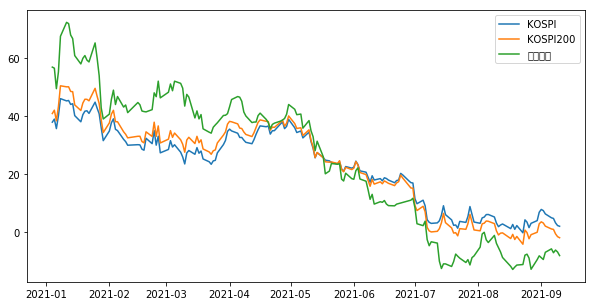

In [77]:
fig = plt.figure(figsize=(10,5))
fig.tight_layout()
subplot = fig.add_subplot(1,1,1)

for k, v in std_dict.items():
    name = v['stock_name']
    ticker_data = v['data']
    subplot.plot(ticker_data['prev_rate180'], label=name)
    subplot.legend()
for k, v in ticker_dict.items():
    if (k in ["005930.KS"]):
        name = v['stock_name']
        ticker_data = v['data']
        subplot.plot(ticker_data['prev_rate180'], label=name)
        subplot.legend()
plt.show()

## 차트 - 100기준 수익률

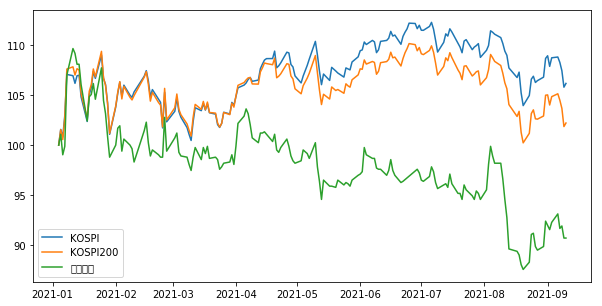

In [76]:
fig = plt.figure(figsize=(10,5))
fig.tight_layout()
subplot = fig.add_subplot(1,1,1)

for k, v in std_dict.items():
    name = v['stock_name']
    ticker_data = v['data']
    subplot.plot(ticker_data['relative_value'], label=name)
    subplot.legend()
for k, v in ticker_dict.items():
    if (k in ["005930.KS"]):
        name = v['stock_name']
        ticker_data = v['data']
        subplot.plot(ticker_data['relative_value'], label=name)
        subplot.legend()
plt.show()

## 차트 - 개별 종목 가격, 이동평균

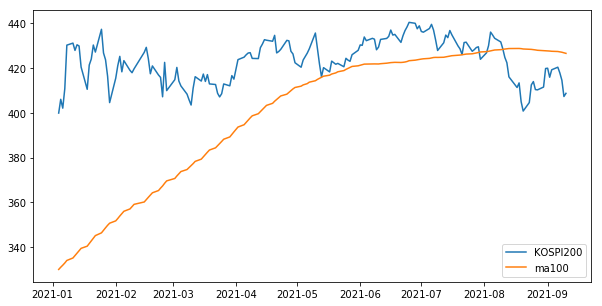

In [75]:
fig = plt.figure(figsize=(10,5))
fig.tight_layout()
subplot = fig.add_subplot(1,1,1)
    
code = "KS200"
ticker_data = std_dict[code]['data']
subplot.plot(ticker_data['Close'], label=std_dict[code]['stock_name'])
#subplot.plot(ticker_data['ma5'], label='ma5')
#subplot.plot(ticker_data['ma25'], label='ma25')
#subplot.plot(ticker_data['ma50'], label='ma50')
subplot.plot(ticker_data['ma100'], label='ma100')
subplot.legend()
plt.show()

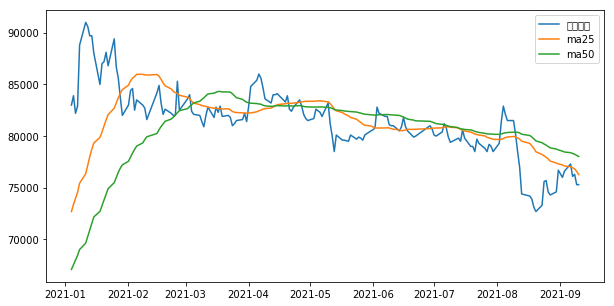

In [74]:
fig = plt.figure(figsize=(10,5))
fig.tight_layout()
subplot = fig.add_subplot(1,1,1)
    
code = "005930.KS"
ticker_data = ticker_dict[code]['data']
subplot.plot(ticker_data['Close'], label=ticker_dict[code]['stock_name'])
#subplot.plot(ticker_data['ma5'], label='ma5')
subplot.plot(ticker_data['ma25'], label='ma25')
subplot.plot(ticker_data['ma50'], label='ma50')
#subplot.plot(ticker_data['ma100'], label='ma100')
subplot.legend()
plt.show()

,High,Low,Open,Close,Volume,Adj Close,prev_close01,prev_close180,prev_rate180,relative_value,ma5,ma25,ma50,ma100
2020-01-02,2185,2130,2135,2180,131658,2180,2115,2700,-19.259259,100.000000,2111.0,2144.8,2209.3,2191.4
2020-01-03,2190,2145,2160,2160,107168,2160,2180,2700,-20.000000,99.082569,2121.0,2143.2,2206.8,2192.1


# 자산 관리 - 종목 매수, 매도

In [60]:
class Stock:
    def __init__(self, code):
        self.code = code
        self.stock_name = stock_cache.get_stock_name(code)
        self.count = 0
        self.buy_price = 0
        self.buy_atr20 = 0
        self.highest_price = 0
        self.price = 0 # current price
        self.ammount = 0
        
    def get_profit_percent(self):
        p = (self.price-self.buy_price)/self.buy_price*100
        return round(p, 2)
    
    def get_profit_amount(self):
        return self.amount - self.buy_price*self.count
        
    def buy(self, count, price, atr20):
        self.count += count
        self.buy_price = price
        self.buy_atr20 = atr20
        self.price = price
        self.apply(price)
        
    def sell(self, count, price):
        self.count -= count
        self.price = price
        self.apply(price)
        
    def apply(self, price):
        self.price = price
        if (price > self.highest_price):
            self.highest_price = price
        self.amount = self.count * self.price
        
class Asset:
    def __init__(self, cash):
        self.stocks = { }
        self.cash = cash
        self.total = cash
    
    def get_stock_count(self):
        return len(self.stocks)
    
    def buy(self, code, count, price, atr20):
        stock = self.get_stock(code)
        
        amount = count * price
        self.cash -= amount # TODO cash 부족시
        stock.buy(count, price, atr20)
        self.eval()
        
    def get_buy_count(self, price):
        count = math.floor(self.cash / price)
        return count
    
    def sell(self, code, price):
        if (not self.is_stock(code)):
            print("Asset.sell(): stock not exist", code)
            return

        stock = self.get_stock(code)
        count = stock.count
        amount = count * price
        stock.sell(count, price)
        self.cash += amount
        
        if (stock.count == 0):
            del self.stocks[code]
        self.eval()
    
    def apply(self, code, price):
        if (self.is_stock(code)):
            stock = self.get_stock(code)
            stock.apply(price)
            self.eval()
        
    def get_stock(self, code):
        if code in self.stocks:
            return self.stocks[code]
        else:
            stock = Stock(code)
            self.stocks[code] = stock;
            return stock
        
    def is_stock(self, code):
        if code in self.stocks:
            return True
        return False
        
    def eval(self):
        stock_total = 0
        for k, v in self.stocks.items():
            stock_total += v.amount
        self.total = stock_total + self.cash
        return self.total
    
    def display(self):
        cash_percent = round(self.cash/self.total*100,2)
        print(f"Asset.display(): total={self.total} cash={self.cash} cash_percent={cash_percent}")
        for k, v in self.stocks.items():
            print("    ", "code=", v.code, "stock_name=", v.stock_name, \
                  "count=", v.count, "price=", v.price, "amount=", v.amount, \
                  "highest_price=", v.highest_price, \
                  "profit_percent=", v.get_profit_percent())


In [228]:
code = "005930.KS"
asset = Asset(10000000)
asset.buy(code, 10, 70000, 1000)
asset.apply(code, 80000)
asset.sell(code, 90000)
asset.display()

Asset.display(): total=10200000 cash=10200000 cash_percent=100.0


# 종목 이벤트 이력

In [61]:
UNKNOWN_TREND = 0
DOWN_TREND = -1
UP_TREND = 1
class StockHistory:
    def __init__(self, code):
        self.code = code
        self.name = stock_cache.get_stock_name(code)
        self.trend = UNKNOWN_TREND
        self.event_histories = [ ]

class StockHistoryStore:
    def __init__(self):
        self.stock_histories = { }
        
    def get_stock_history(self, code):
        if code in self.stock_histories:
            return self.stock_histories[code]
        else:
            stock_history = StockHistory(code)
            self.stock_histories[code] = stock_history;
            return stock_history

# 시스템

In [230]:
batch_data = pd.DataFrame()
idx = '2020-01-02'
for k, v in ticker_dict.items():
    copy = v['data'].loc[idx].copy() # ticker_data
    copy['code'] = k # code 컬럼 추가
    batch_data = batch_data.append(copy)
batch_filtered_data = batch_data[batch_data.ma25 > batch_data.ma50]
batch_filtered_data.sort_values(by='prev_rate180', ascending=False)

,Adj Close,Close,High,Low,Open,Volume,ata20,atr20,code,ma100,ma25,ma5,ma50,prev_close01,prev_close180,prev_rate180,relative_value,ta,tr
2020-01-02,3020.000000,3020.0,3145.0,2855.0,2860.0,16067989.0,4.395189e+10,284.75,021050.KS,1412.000000,2203.80,2772.0,1709.600000,2830.0,1265.000000,138.735178,100.0,4.852533e+10,290.0
2020-01-02,12000.000000,12000.0,12250.0,11850.0,12100.0,378657.0,6.379474e+09,599.50,007810.KS,7803.550000,10797.60,11080.0,10253.600000,11500.0,5470.000000,119.378428,100.0,4.543884e+09,400.0
2020-01-02,8100.000000,8100.0,8180.0,7960.0,8110.0,1029138.0,2.290944e+10,653.50,003580.KS,5946.650000,8045.60,8006.0,7881.000000,7900.0,4055.000000,99.753391,100.0,8.336018e+09,220.0
2020-01-02,3345.000000,3345.0,3375.0,3180.0,3290.0,2561318.0,1.165883e+10,188.50,002410.KS,1767.150000,2262.80,3221.0,1958.500000,3360.0,1830.000000,82.786885,100.0,8.567609e+09,195.0
2020-01-02,27688.865234,27900.0,28600.0,27700.0,27950.0,658702.0,2.243148e+10,1100.00,000990.KS,17559.000000,22466.00,27060.0,19956.000000,28150.0,15900.000000,75.471698,100.0,1.837779e+10,900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-02,2000.000000,2000.0,2050.0,1590.0,1622.0,18449634.0,1.855008e+10,386.70,009810.KS,1826.700000,2119.84,2080.4,1830.920000,1648.0,2680.000000,-25.373134,100.0,3.689927e+10,460.0
2020-01-02,1345.000000,1345.0,1350.0,1295.0,1295.0,287232.0,5.096168e+08,55.25,090370.KS,1390.600000,1369.40,1320.0,1354.600000,1310.0,1805.000000,-25.484765,100.0,3.863270e+08,55.0
2020-01-02,11250.000000,11250.0,11550.0,11100.0,11550.0,600262.0,4.993321e+09,575.00,267260.KS,9765.186221,9392.40,10322.0,9240.870391,10850.0,15290.299805,-26.423941,100.0,6.752948e+09,450.0
2020-01-02,8190.000000,8190.0,8240.0,8010.0,8010.0,26036.0,6.994985e+08,307.50,011810.KS,8116.100000,7966.40,8074.0,7872.200000,8060.0,11700.000000,-30.000000,100.0,2.132348e+08,230.0


In [231]:
code = "005930.KS"
idx = '2020-01-02'
ticker_data = ticker_dict[code]['data']
ticker_data.loc[idx]

High              5.600000e+04
Low               5.500000e+04
Open              5.550000e+04
Close             5.520000e+04
Volume            1.299323e+07
Adj Close         5.230561e+04
prev_close01      5.650000e+04
prev_close180     4.625000e+04
prev_rate180      1.935135e+01
relative_value    1.000000e+02
ma5               5.552000e+04
ma25              5.307800e+04
ma50              5.241700e+04
ma100             4.935000e+04
tr                1.000000e+03
atr20             9.850000e+02
ta                7.172262e+11
ata20             7.223392e+11
Name: 2020-01-02 00:00:00, dtype: float64

In [80]:
class LTHM: # LongTrendHighMomentum
    def __init__(self, max_percent=10, cash=100000000): # 1억원
        self.MAX_POSITION_PERCENT = max_percent # 전체 자산 대비 종목별 최대 비중
        self.RISK_PERCENT = 2 # 손실 위험
        self.MIN_TRADING_AMOUNT = 60 * 1000 * 1000 * 1200 # 6백억
        self.MIN_PRICE = 6000 # 6천원 이상
        self.ATR_MULTIPLY = 2 # stop loss=ATR*ATR_MULTIPLY
        self.PROFIT_RESERVE_PERCENT = 10
        self.stock_history_store = StockHistoryStore()
        self.asset = Asset(cash)
        self.data = pd.DataFrame(columns=['total', 'cash'])
        self.action_histories = [ ]
    
    # 모든 종목에 대해 idx row를 합쳐 batch_data 생성
    def make_batch_data(self, idx):
        batch_data = pd.DataFrame()
        for k, v in ticker_dict.items():
            if (idx in v['data'].index):
                copy = v['data'].loc[idx].copy()
                copy['code'] = k
                batch_data = batch_data.append(copy)
        return batch_data
    
    def filter_batch_data(self, batch_data):  
        if (len(batch_data) == 0):
            return batch_data
        
        # 종목 거래 금액, 주가, 이동 평균 filter
        filtered_data = batch_data[\
            (batch_data['ata20'] > self.MIN_TRADING_AMOUNT) &\
            (batch_data['Close'] > self.MIN_PRICE) &\
            (batch_data.ma25 > batch_data.ma50)]
        return filtered_data
    
    def prioritize_batch_data(self, batch_data):
        return batch_data.sort_values(by='prev_rate180', ascending=False)
    
    def backtest(self):
        ticker_data = ticker_dict['005930.KS']['data'] # idx 가져오기 위해 삼성전자 종목 사용
        for idx, row in ticker_data.iterrows():
            self.apply(idx)
        
        add_relative_value(self.data, 'total') # total 값을 이용하여 relative_value 컬럼 추가
        return
    
    def apply(self, idx):       
        # 신규 종목 체크
        if (self.is_available_position()):
            batch_data = self.make_batch_data(idx)
            batch_data = self.filter_batch_data(batch_data)
            batch_data = self.prioritize_batch_data(batch_data)
            #print("LTHM.apply():", "idx=", idx, "batch_data_len=", len(batch_data))
            for idx, row in batch_data.iterrows():
                code = row['code']
                self.apply_stock(code, idx, row)
  
        # 보유 종목 체크
        for k in list(self.asset.stocks.keys()):
            code = k
            ticker_data = ticker_dict[code]['data']
            if (idx in ticker_data.index):
                row = ticker_data.loc[idx]
                self.apply_stock(code, idx, row)
            else:
                print(f"LTHM.apply(): ticker_data index not found, ignored: idx={idx} code={code}")

        self.data = self.data.append(pd.Series({'total':self.asset.total, 'cash':self.asset.cash}, index=self.data.columns, name=idx))
        
    def apply_stock(self, code, idx, row):
        stock_history = self.stock_history_store.get_stock_history(code)
        price = row['Close']
        atr20 = row['atr20']
        self.asset.apply(code, price)
        
        if (not self.asset.is_stock(code) and \
            self.is_ks200_satisfied(idx) and \
            self.is_uptrend(stock_history, idx, row)):
            count = self.get_buy_count(price, atr20)
            if (count > 0):
                action = { "name": "buy", "idx": idx.strftime('%Y-%m-%d'), "code": code, "stock_name": stock_history.name, "count": count, "price": price}
                print("action:", action)
                self.asset.buy(code, count, price, atr20)
                self.asset.display()
                self.action_histories.append(action)
                
        if (self.asset.is_stock(code)):
            stock = self.asset.get_stock(code)
            count = stock.count
            if (self.is_stop_loss(stock, row) or \
               self.is_profit_reserve(stock, row)):
                self.asset.sell(code, price)
                action = {"name": "sell", \
                          "idx": idx.strftime('%Y-%m-%d'), \
                          "code": code, \
                          "stock_name": stock_history.name, \
                          "count": count, \
                          "price": price, \
                          "buy_price": stock.buy_price, \
                          "profit_percent": stock.get_profit_percent()}
                print("action:", action)
                self.asset.display()
                self.action_histories.append(action)

    def is_ks200_satisfied(self, idx):
        code = "KS200"
        ticker_data = std_dict[code]['data']
        row = ticker_data.loc[idx]
        if (row['Close'] > row['ma100']):
            return True
        return False
    
    # 총자산 대비 위험 비율
    def get_buy_count(self, price, atr20):
        if (not self.is_available_position()):
            return 0
        position_limit = self.get_position_limit() # 포지션 최대 금액
        position_risk_amount = math.floor(self.asset.total * self.RISK_PERCENT / 100) # 포지션 위험 부담 금액
        stop_loss_amount = atr20*self.ATR_MULTIPLY # 주당 위험 부담 금액
        
        # buy count(포지션 크기) 계산
        buy_count = math.floor(position_risk_amount / stop_loss_amount)
        position_amount = buy_count * price
        if (position_amount > position_limit):
            position_amount = position_limit
            buy_count = math.floor(position_amount / price)
        print(f"LTHM.get_buy_count(): buy_count={buy_count} position_amount={position_amount} \
            total={self.asset.total} cash={self.asset.cash} position_limit{position_limit}")
        return buy_count
    
    # 총자산 대비 금액 비율
    def get_buy_count_old(self, price):       
        if (not self.is_available_position()):
            return 0
        position_cash = self.asset.cash / available_position_count
        position_limit = self.asset.total * self.MAX_POSITION_PERCENT / 100
        print("LTHM.get_buy_count():", "position_cash=", position_cash, "position_limit=", position_limit)
        if (position_cash > position_limit):
            position_cash = position_limit
        return math.floor(position_cash / price)
    
    def get_position_limit(self):
        return math.floor(self.asset.total*self.MAX_POSITION_PERCENT/100)
    
    def is_available_position(self):
        if (self.asset.cash/self.asset.total*100 >= self.MAX_POSITION_PERCENT):
            return True
        return False
    
    def is_uptrend(self, stock_history, idx, row):
        if (row['ma25'] > row['ma50']):
            stock_history.trend = UP_TREND
            return True
        return False        

    def is_downtrend(self, stock_history, idx, row):
        if (row['ma25'] < row['ma50']):
            stock_history.trend = DOWN_TREND
            return True
        return False
    
    def is_stop_loss(self, stock, row):
        price = row['Close']
        if (price < stock.buy_price and ((stock.buy_price-price) > stock.buy_atr20*self.ATR_MULTIPLY)):
            print("LTHM.is_stop_loss():", "code=", stock.code, "stock_name=", stock.stock_name, \
                  "buy_price=", stock.buy_price, "price=", price, "buy_atr20=", stock.buy_atr20)
            return True
        return False

    def is_profit_reserve(self, stock, row):
        price = row['Close']
        if (price < stock.highest_price*(1-self.PROFIT_RESERVE_PERCENT/100)):
            print("LTHM.is_profit_reserve():", "code=", stock.code, "stock_name=", stock.stock_name, \
                  "buy_price=", stock.buy_price, "price=", price, "highest_price=", stock.highest_price)
            return True
        return False
    
    def on_gold_cross(self, stock_history, idx, row):
        code = stock_history.code
        stock_name = stock_history.name
        if (stock_history.trend != UP_TREND and row['ma25'] > row['ma50']):
            stock_history.trend = UP_TREND
            event = { "idx": idx.strftime('%Y-%m-%d'), "code": code, "stock_name": stock_name, "name": "uptrend"}
            stock_history.event_histories.append(event)
            print("event:", event)
            return True
        return False
    
    def on_dead_cross(self, stock_history, idx, row):
        code = stock_history.code
        stock_name = stock_history.name
        if (stock_history.trend != DOWN_TREND and row['ma25'] < row['ma50']):
            stock_history.trend = DOWN_TREND
            event = { "idx": idx.strftime('%Y-%m-%d'), "code": code, "stock_name": stock_name, "name": "downtrend"}
            stock_history.event_histories.append(event)
            print("event:", event)
            return True
        return False


## 시스템 - position=1

In [ ]:
system = LTHM(max_percent=100)
system.backtest()
#system.action_histories

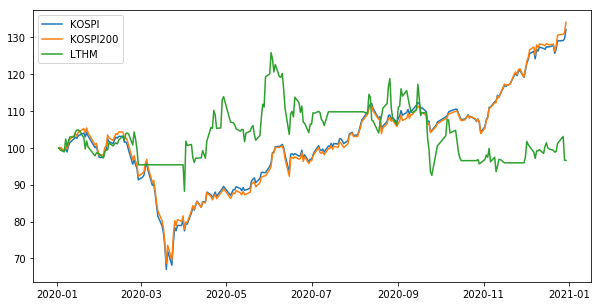

In [76]:
show_chart()

## 시스템 - position=3

In [ ]:
system = LTHM(max_percent=33)
system.backtest()
#system.apply('2020-01-02')
#system.apply('2020-01-03')
#system.action_histories

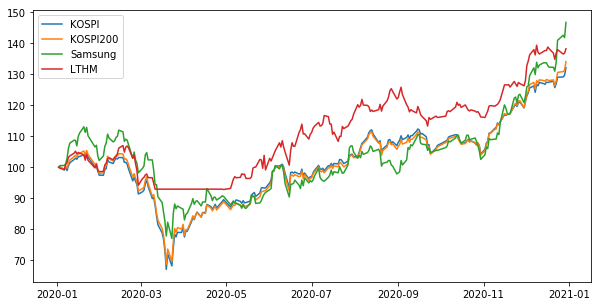

In [31]:
show_chart()

## 시스템 - position=10

In [81]:
system = LTHM(max_percent=10)
system.backtest()

LTHM.get_buy_count(): buy_count=105 position_amount=10000000             total=100000000 cash=100000000 position_limit10000000
action: {'name': 'buy', 'idx': '2020-01-02', 'code': '000660.KS', 'stock_name': 'SK하이닉스', 'count': 105, 'price': 94700.0}
Asset.display(): total=100000000.0 cash=90056500.0 cash_percent=90.06
     code= 000660.KS stock_name= SK하이닉스 count= 105 price= 94700.0 amount= 9943500.0 highest_price= 94700.0 profit_percent= 0.0
LTHM.get_buy_count(): buy_count=250 position_amount=10000000             total=100000000.0 cash=90056500.0 position_limit10000000
action: {'name': 'buy', 'idx': '2020-01-02', 'code': '180640.KS', 'stock_name': '한진칼', 'count': 250, 'price': 39950.0}
Asset.display(): total=100000000.0 cash=80069000.0 cash_percent=80.07
     code= 000660.KS stock_name= SK하이닉스 count= 105 price= 94700.0 amount= 9943500.0 highest_price= 94700.0 profit_percent= 0.0
     code= 180640.KS stock_name= 한진칼 count= 250 price= 39950.0 amount= 9987500.0 highest_price= 39950.0 prof

LTHM.get_buy_count(): buy_count=304 position_amount=10062641             total=100626411.921875 cash=27898071.125 position_limit10062641
action: {'name': 'buy', 'idx': '2020-01-21', 'code': '035720.KS', 'stock_name': '카카오', 'count': 304, 'price': 33000.0}
Asset.display(): total=100626411.921875 cash=17866071.125 cash_percent=17.75
     code= 000660.KS stock_name= SK하이닉스 count= 105 price= 99300.0 amount= 10426500.0 highest_price= 100500.0 profit_percent= 4.86
     code= 180640.KS stock_name= 한진칼 count= 250 price= 40250.0 amount= 10062500.0 highest_price= 42650.0 profit_percent= 0.75
     code= 005930.KS stock_name= 삼성전자 count= 181 price= 61400.0 amount= 11113400.0 highest_price= 62400.0 profit_percent= 11.23
     code= 009150.KS stock_name= 삼성전기 count= 78 price= 133500.0 amount= 10413000.0 highest_price= 136500.0 profit_percent= 4.71
     code= 006400.KS stock_name= 삼성SDI count= 38 price= 275500.0 amount= 10469000.0 highest_price= 275500.0 profit_percent= 2.61
     code= 068270.KS stock

LTHM.is_profit_reserve(): code= 000660.KS stock_name= SK하이닉스 buy_price= 94700.0 price= 92800.0 highest_price= 105000.0
action: {'name': 'sell', 'idx': '2020-02-27', 'code': '000660.KS', 'stock_name': 'SK하이닉스', 'count': 105, 'price': 92800.0, 'buy_price': 94700.0, 'profit_percent': -2.01}
Asset.display(): total=105671733.90625 cash=25750571.125 cash_percent=24.37
     code= 180640.KS stock_name= 한진칼 count= 250 price= 65000.0 amount= 16250000.0 highest_price= 65000.0 profit_percent= 62.7
     code= 005930.KS stock_name= 삼성전자 count= 181 price= 56500.0 amount= 10226500.0 highest_price= 62400.0 profit_percent= 2.36
     code= 009150.KS stock_name= 삼성전기 count= 78 price= 131500.0 amount= 10257000.0 highest_price= 146000.0 profit_percent= 3.14
     code= 006400.KS stock_name= 삼성SDI count= 38 price= 312000.0 amount= 11856000.0 highest_price= 343500.0 profit_percent= 16.2
     code= 068270.KS stock_name= 셀트리온 count= 59 price= 169607.84375 amount= 10006862.78125 highest_price= 182352.9375 profit_

Asset.display(): total=103949710.59375 cash=20894628.477539062 cash_percent=20.1
     code= 019170.KS stock_name= 신풍제약 count= 504 price= 20600.0 amount= 10382400.0 highest_price= 20600.0 profit_percent= 0.0
     code= 005690.KS stock_name= 파미셀 count= 438 price= 23700.0 amount= 10380600.0 highest_price= 23700.0 profit_percent= 0.0
     code= 180640.KS stock_name= 한진칼 count= 116 price= 89200.0 amount= 10347200.0 highest_price= 89200.0 profit_percent= 0.0
     code= 026890.KS stock_name= 디피씨 count= 859 price= 12100.0 amount= 10393900.0 highest_price= 12100.0 profit_percent= 0.0
     code= 008350.KS stock_name= 남선알미늄 count= 1565 price= 6640.0 amount= 10391600.0 highest_price= 6640.0 profit_percent= 0.0
     code= 003000.KS stock_name= 부광약품 count= 442 price= 23500.0 amount= 10387000.0 highest_price= 23500.0 profit_percent= 0.0
     code= 336260.KS stock_name= 두산퓨얼셀 count= 727 price= 14284.8447265625 amount= 10385082.116210938 highest_price= 14284.8447265625 profit_percent= 0.0
     code= 01

LTHM.is_profit_reserve(): code= 005690.KS stock_name= 파미셀 buy_price= 23700.0 price= 21550.0 highest_price= 24100.0
action: {'name': 'sell', 'idx': '2020-06-05', 'code': '005690.KS', 'stock_name': '파미셀', 'count': 438, 'price': 21550.0, 'buy_price': 23700.0, 'profit_percent': -9.07}
Asset.display(): total=100273308.88183594 cash=28213700.026367188 cash_percent=28.14
     code= 019170.KS stock_name= 신풍제약 count= 504 price= 20450.0 amount= 10306800.0 highest_price= 21700.0 profit_percent= -0.73
     code= 180640.KS stock_name= 한진칼 count= 116 price= 90900.0 amount= 10544400.0 highest_price= 93300.0 profit_percent= 1.91
     code= 008350.KS stock_name= 남선알미늄 count= 1565 price= 6140.0 amount= 9609100.0 highest_price= 6640.0 profit_percent= -7.53
     code= 003000.KS stock_name= 부광약품 count= 442 price= 24954.544921875 amount= 11029908.85546875 highest_price= 25000.0 profit_percent= 6.19
     code= 035720.KS stock_name= 카카오 count= 199 price= 50800.0 amount= 10109200.0 highest_price= 53400.0 profi

LTHM.is_stop_loss(): code= 008350.KS stock_name= 남선알미늄 buy_price= 6640.0 price= 5650.0 buy_atr20= 316.75
action: {'name': 'sell', 'idx': '2020-06-15', 'code': '008350.KS', 'stock_name': '남선알미늄', 'count': 1565, 'price': 5650.0, 'buy_price': 6640.0, 'profit_percent': -14.91}
Asset.display(): total=116743230.45800781 cash=16985869.219726562 cash_percent=14.55
     code= 019170.KS stock_name= 신풍제약 count= 504 price= 34300.0 amount= 17287200.0 highest_price= 34300.0 profit_percent= 66.5
     code= 003000.KS stock_name= 부광약품 count= 442 price= 32590.908203125 amount= 14405181.42578125 highest_price= 35409.08984375 profit_percent= 38.68
     code= 035720.KS stock_name= 카카오 count= 199 price= 50500.0 amount= 10049500.0 highest_price= 53400.0 profit_percent= -3.07
     code= 207940.KS stock_name= 삼성바이오로직스 count= 16 price= 808000.0 amount= 12928000.0 highest_price= 808000.0 profit_percent= 29.49
     code= 007570.KS stock_name= 일양약품 count= 191 price= 56000.0 amount= 10696000.0 highest_price= 56000.

LTHM.get_buy_count(): buy_count=836 position_amount=12624543             total=126245430.70410156 cash=21395915.739257812 position_limit12624543
action: {'name': 'buy', 'idx': '2020-07-09', 'code': '026890.KS', 'stock_name': '디피씨', 'count': 836, 'price': 15100.0}
Asset.display(): total=126245430.70410156 cash=8772315.739257812 cash_percent=6.95
     code= 035720.KS stock_name= 카카오 count= 199 price= 65600.0 amount= 13054400.0 highest_price= 65600.0 profit_percent= 25.91
     code= 007570.KS stock_name= 일양약품 count= 191 price= 68600.0 amount= 13102600.0 highest_price= 69700.0 profit_percent= 22.5
     code= 068270.KS stock_name= 셀트리온 count= 43 price= 305392.15625 amount= 13131862.71875 highest_price= 312745.09375 profit_percent= 13.69
     code= 006400.KS stock_name= 삼성SDI count= 33 price= 385500.0 amount= 12721500.0 highest_price= 391000.0 profit_percent= 10.62
     code= 036570.KS stock_name= 엔씨소프트 count= 14 price= 945000.0 amount= 13230000.0 highest_price= 995000.0 profit_percent= 16.6

LTHM.get_buy_count(): buy_count=250 position_amount=15809448             total=158094480.7314453 cash=16273451.184570312 position_limit15809448
action: {'name': 'buy', 'idx': '2020-07-21', 'code': '035720.KS', 'stock_name': '카카오', 'count': 250, 'price': 63200.0}
Asset.display(): total=158094480.7314453 cash=473451.1845703125 cash_percent=0.3
     code= 068270.KS stock_name= 셀트리온 count= 43 price= 316666.65625 amount= 13616666.21875 highest_price= 322549.03125 profit_percent= 17.88
     code= 006400.KS stock_name= 삼성SDI count= 33 price= 378500.0 amount= 12490500.0 highest_price= 394000.0 profit_percent= 8.61
     code= 019170.KS stock_name= 신풍제약 count= 391 price= 94900.0 amount= 37105900.0 highest_price= 94900.0 profit_percent= 208.62
     code= 180640.KS stock_name= 한진칼 count= 138 price= 93900.0 amount= 12958200.0 highest_price= 99000.0 profit_percent= 10.34
     code= 026890.KS stock_name= 디피씨 count= 836 price= 17000.0 amount= 14212000.0 highest_price= 18600.0 profit_percent= 12.58
   

     code= 035720.KS stock_name= 카카오 count= 250 price= 65900.0 amount= 16475000.0 highest_price= 65900.0 profit_percent= 4.27
     code= 019170.KS stock_name= 신풍제약 count= 145 price= 71600.0 amount= 10382000.0 highest_price= 73500.0 profit_percent= -2.59
     code= 006120.KS stock_name= SK디스커버리 count= 325 price= 52000.0 amount= 16900000.0 highest_price= 52100.0 profit_percent= -0.19
     code= 006280.KS stock_name= 녹십자 count= 71 price= 235500.0 amount= 16720500.0 highest_price= 237500.0 profit_percent= -0.84
     code= 192650.KS stock_name= 드림텍 count= 1529 price= 11474.5029296875 amount= 17544514.979492188 highest_price= 11474.5029296875 profit_percent= 3.57
LTHM.get_buy_count(): buy_count=61 position_amount=16894414             total=168944148.13671875 cash=33078018.501953125 position_limit16894414
action: {'name': 'buy', 'idx': '2020-07-30', 'code': '285130.KS', 'stock_name': 'SK케미칼', 'count': 61, 'price': 274000.0}
Asset.display(): total=168944148.13671875 cash=16364018.501953125 cas

LTHM.get_buy_count(): buy_count=1137 position_amount=20202188             total=202021884.359375 cash=57804389.984375 position_limit20202188
action: {'name': 'buy', 'idx': '2020-08-12', 'code': '192650.KS', 'stock_name': '드림텍', 'count': 1137, 'price': 17755.8046875}
Asset.display(): total=202021884.359375 cash=37616040.0546875 cash_percent=18.62
     code= 068270.KS stock_name= 셀트리온 count= 43 price= 307843.125 amount= 13237254.375 highest_price= 322549.03125 profit_percent= 14.6
     code= 006400.KS stock_name= 삼성SDI count= 33 price= 472500.0 amount= 15592500.0 highest_price= 488000.0 profit_percent= 35.58
     code= 035720.KS stock_name= 카카오 count= 250 price= 70500.0 amount= 17625000.0 highest_price= 74100.0 profit_percent= 11.55
     code= 006120.KS stock_name= SK디스커버리 count= 325 price= 77300.0 amount= 25122500.0 highest_price= 77300.0 profit_percent= 48.37
     code= 006280.KS stock_name= 녹십자 count= 71 price= 301500.0 amount= 21406500.0 highest_price= 301500.0 profit_percent= 26.95


LTHM.get_buy_count(): buy_count=751 position_amount=19803513             total=198035139.73339844 cash=24354683.327148438 position_limit19803513
action: {'name': 'buy', 'idx': '2020-08-20', 'code': '004720.KS', 'stock_name': '팜젠사이언스', 'count': 751, 'price': 26350.0}
Asset.display(): total=198035139.73339844 cash=4565833.3271484375 cash_percent=2.31
     code= 068270.KS stock_name= 셀트리온 count= 43 price= 298039.21875 amount= 12815686.40625 highest_price= 322549.03125 profit_percent= 10.95
     code= 035720.KS stock_name= 카카오 count= 250 price= 75300.0 amount= 18825000.0 highest_price= 75600.0 profit_percent= 19.15
     code= 006280.KS stock_name= 녹십자 count= 71 price= 301000.0 amount= 21371000.0 highest_price= 301500.0 profit_percent= 26.74
     code= 000910.KS stock_name= 유니온 count= 1878 price= 9540.0 amount= 17916120.0 highest_price= 10050.0 profit_percent= 6.24
     code= 019170.KS stock_name= 신풍제약 count= 114 price= 93200.0 amount= 10624800.0 highest_price= 93200.0 profit_percent= 26.8


LTHM.get_buy_count(): buy_count=765 position_amount=20054558             total=200545587.79589844 cash=61055473.32714844 position_limit20054558
action: {'name': 'buy', 'idx': '2020-08-28', 'code': '011000.KS', 'stock_name': '진원생명과학', 'count': 765, 'price': 26200.0}
Asset.display(): total=200545587.79589844 cash=41012473.32714844 cash_percent=20.45
     code= 068270.KS stock_name= 셀트리온 count= 43 price= 298529.40625 amount= 12836764.46875 highest_price= 322549.03125 profit_percent= 11.13
     code= 035720.KS stock_name= 카카오 count= 250 price= 82100.0 amount= 20525000.0 highest_price= 82100.0 profit_percent= 29.91
     code= 019170.KS stock_name= 신풍제약 count= 114 price= 111000.0 amount= 12654000.0 highest_price= 114000.0 profit_percent= 51.02
     code= 007570.KS stock_name= 일양약품 count= 224 price= 80700.0 amount= 18076800.0 highest_price= 84800.0 profit_percent= -4.83
     code= 285130.KS stock_name= SK케미칼 count= 51 price= 393000.0 amount= 20043000.0 highest_price= 416500.0 profit_percent= 

     code= 003090.KS stock_name= 대웅 count= 589 price= 37950.0 amount= 22352550.0 highest_price= 38800.0 profit_percent= 15.0
     code= 066570.KS stock_name= LG전자 count= 232 price= 83800.0 amount= 19441600.0 highest_price= 90600.0 profit_percent= -0.24
     code= 011000.KS stock_name= 진원생명과학 count= 765 price= 27150.0 amount= 20769750.0 highest_price= 29100.0 profit_percent= 3.63
     code= 006120.KS stock_name= SK디스커버리 count= 284 price= 75300.0 amount= 21385200.0 highest_price= 77400.0 profit_percent= 7.26
     code= 003000.KS stock_name= 부광약품 count= 571 price= 32636.36328125 amount= 18635363.43359375 highest_price= 34909.08984375 profit_percent= -6.51
LTHM.is_profit_reserve(): code= 285130.KS stock_name= SK케미칼 buy_price= 379000.0 price= 370500.0 highest_price= 416500.0
action: {'name': 'sell', 'idx': '2020-09-08', 'code': '285130.KS', 'stock_name': 'SK케미칼', 'count': 51, 'price': 370500.0, 'buy_price': 379000.0, 'profit_percent': -2.24}
Asset.display(): total=203854063.55371094 cash=66

LTHM.get_buy_count(): buy_count=580 position_amount=15225000.0             total=205900445.2705078 cash=28057100.120117188 position_limit20590044
action: {'name': 'buy', 'idx': '2020-09-10', 'code': '011000.KS', 'stock_name': '진원생명과학', 'count': 580, 'price': 26250.0}
Asset.display(): total=205900445.2705078 cash=12832100.120117188 cash_percent=6.23
     code= 035720.KS stock_name= 카카오 count= 250 price= 76800.0 amount= 19200000.0 highest_price= 82400.0 profit_percent= 21.52
     code= 000020.KS stock_name= 동화약품 count= 612 price= 24550.0 amount= 15024600.0 highest_price= 25550.0 profit_percent= 11.59
     code= 066570.KS stock_name= LG전자 count= 232 price= 90200.0 amount= 20926400.0 highest_price= 90600.0 profit_percent= 7.38
     code= 006120.KS stock_name= SK디스커버리 count= 284 price= 69700.0 amount= 19794800.0 highest_price= 77400.0 profit_percent= -0.71
     code= 003000.KS stock_name= 부광약품 count= 571 price= 31454.544921875 amount= 17960545.150390625 highest_price= 34909.08984375 profit_

LTHM.is_profit_reserve(): code= 019170.KS stock_name= 신풍제약 buy_price= 139500.0 price= 166000.0 highest_price= 198000.0
action: {'name': 'sell', 'idx': '2020-09-22', 'code': '019170.KS', 'stock_name': '신풍제약', 'count': 143, 'price': 166000.0, 'buy_price': 139500.0, 'profit_percent': 19.0}
Asset.display(): total=212081936.68652344 cash=54976543.62402344 cash_percent=25.92
     code= 000020.KS stock_name= 동화약품 count= 612 price= 25050.0 amount= 15330600.0 highest_price= 26750.0 profit_percent= 13.86
     code= 066570.KS stock_name= LG전자 count= 232 price= 90900.0 amount= 21088800.0 highest_price= 93200.0 profit_percent= 8.21
     code= 037270.KS stock_name= YG PLUS count= 3300 price= 6900.0 amount= 22770000.0 highest_price= 7010.0 profit_percent= 13.86
     code= 011000.KS stock_name= 진원생명과학 count= 580 price= 39000.0 amount= 22620000.0 highest_price= 39000.0 profit_percent= 48.57
     code= 035420.KS stock_name= NAVER count= 66 price= 292000.0 amount= 19272000.0 highest_price= 312000.0 profi

LTHM.get_buy_count(): buy_count=119 position_amount=19635000.0             total=211136866.6220703 cash=24582143.624023438 position_limit21113686
action: {'name': 'buy', 'idx': '2020-09-23', 'code': '019170.KS', 'stock_name': '신풍제약', 'count': 119, 'price': 165000.0}
Asset.display(): total=211136866.6220703 cash=4947143.6240234375 cash_percent=2.34
     code= 066570.KS stock_name= LG전자 count= 232 price= 88900.0 amount= 20624800.0 highest_price= 93200.0 profit_percent= 5.83
     code= 037270.KS stock_name= YG PLUS count= 3300 price= 6950.0 amount= 22935000.0 highest_price= 7010.0 profit_percent= 14.69
     code= 011000.KS stock_name= 진원생명과학 count= 580 price= 42400.0 amount= 24592000.0 highest_price= 42400.0 profit_percent= 61.52
     code= 033270.KS stock_name= 유나이티드제약 count= 184 price= 79500.0 amount= 14628000.0 highest_price= 79500.0 profit_percent= 2.58
     code= 034020.KS stock_name= 두산중공업 count= 1498 price= 13120.7763671875 amount= 19654922.998046875 highest_price= 13495.65625 prof

LTHM.get_buy_count(): buy_count=102 position_amount=13668000.0             total=197221288.3701172 cash=37259551.4453125 position_limit19722128
action: {'name': 'buy', 'idx': '2020-10-06', 'code': '019170.KS', 'stock_name': '신풍제약', 'count': 102, 'price': 134000.0}
Asset.display(): total=197221288.3701172 cash=23591551.4453125 cash_percent=11.96
     code= 066570.KS stock_name= LG전자 count= 232 price= 92100.0 amount= 21367200.0 highest_price= 93200.0 profit_percent= 9.64
     code= 285130.KS stock_name= SK케미칼 count= 70 price= 299000.0 amount= 20930000.0 highest_price= 305000.0 profit_percent= -1.97
     code= 096770.KS stock_name= SK이노베이션 count= 140 price= 141000.0 amount= 19740000.0 highest_price= 151000.0 profit_percent= -6.62
     code= 009830.KS stock_name= 한화솔루션 count= 563 price= 41069.0 amount= 23121847.0 highest_price= 41069.0 profit_percent= 19.91
     code= 011000.KS stock_name= 진원생명과학 count= 496 price= 30650.0 amount= 15202400.0 highest_price= 32150.0 profit_percent= -4.67
    

LTHM.get_buy_count(): buy_count=1688 position_amount=19928363             total=199283630.5517578 cash=27883300.551757812 position_limit19928363
action: {'name': 'buy', 'idx': '2020-10-15', 'code': '034020.KS', 'stock_name': '두산중공업', 'count': 1688, 'price': 11800.0}
Asset.display(): total=199283630.5517578 cash=7964900.5517578125 cash_percent=4.0
     code= 066570.KS stock_name= LG전자 count= 232 price= 91400.0 amount= 21204800.0 highest_price= 96100.0 profit_percent= 8.81
     code= 285130.KS stock_name= SK케미칼 count= 70 price= 346000.0 amount= 24220000.0 highest_price= 355500.0 profit_percent= 13.44
     code= 096770.KS stock_name= SK이노베이션 count= 140 price= 142500.0 amount= 19950000.0 highest_price= 151000.0 profit_percent= -5.63
     code= 009830.KS stock_name= 한화솔루션 count= 563 price= 45210.0 amount= 25453230.0 highest_price= 47840.69921875 profit_percent= 32.01
     code= 011000.KS stock_name= 진원생명과학 count= 496 price= 31750.0 amount= 15748000.0 highest_price= 32550.0 profit_percent= -

LTHM.get_buy_count(): buy_count=686 position_amount=19047998             total=190479988.86035156 cash=30955513.317382812 position_limit19047998
action: {'name': 'buy', 'idx': '2020-10-23', 'code': '042670.KS', 'stock_name': '두산인프라코어', 'count': 686, 'price': 27761.900390625}
Asset.display(): total=190479988.86035156 cash=11910849.649414062 cash_percent=6.25
     code= 066570.KS stock_name= LG전자 count= 232 price= 88400.0 amount= 20508800.0 highest_price= 96100.0 profit_percent= 5.24
     code= 096770.KS stock_name= SK이노베이션 count= 140 price= 136500.0 amount= 19110000.0 highest_price= 151000.0 profit_percent= -9.6
     code= 035720.KS stock_name= 카카오 count= 279 price= 69800.0 amount= 19474200.0 highest_price= 76300.0 profit_percent= -0.71
     code= 019170.KS stock_name= 신풍제약 count= 110 price= 139000.0 amount= 15290000.0 highest_price= 139000.0 profit_percent= 10.32
     code= 034020.KS stock_name= 두산중공업 count= 1688 price= 13700.0 amount= 23125600.0 highest_price= 13700.0 profit_percent= 

LTHM.get_buy_count(): buy_count=424 position_amount=18266756             total=182667566.1064453 cash=32824477.106445312 position_limit18266756
action: {'name': 'buy', 'idx': '2020-10-27', 'code': '009830.KS', 'stock_name': '한화솔루션', 'count': 424, 'price': 43017.69921875}
Asset.display(): total=182667566.1064453 cash=14584972.637695312 cash_percent=7.98
     code= 066570.KS stock_name= LG전자 count= 232 price= 89100.0 amount= 20671200.0 highest_price= 96100.0 profit_percent= 6.07
     code= 019170.KS stock_name= 신풍제약 count= 110 price= 127000.0 amount= 13970000.0 highest_price= 139000.0 profit_percent= 0.79
     code= 034020.KS stock_name= 두산중공업 count= 1688 price= 13150.0 amount= 22197200.0 highest_price= 13900.0 profit_percent= 11.44
     code= 042670.KS stock_name= 두산인프라코어 count= 686 price= 27536.5 amount= 18890039.0 highest_price= 27761.900390625 profit_percent= -0.81
     code= 005380.KS stock_name= 현대차 count= 108 price= 171500.0 amount= 18522000.0 highest_price= 171500.0 profit_percen

LTHM.get_buy_count(): buy_count=48 position_amount=19511079             total=195110798.6376953 cash=28621822.637695312 position_limit19511079
action: {'name': 'buy', 'idx': '2020-11-12', 'code': '285130.KS', 'stock_name': 'SK케미칼', 'count': 48, 'price': 399500.0}
Asset.display(): total=195110798.6376953 cash=9445822.637695312 cash_percent=4.84
     code= 034020.KS stock_name= 두산중공업 count= 1688 price= 16400.0 amount= 27683200.0 highest_price= 16400.0 profit_percent= 38.98
     code= 042670.KS stock_name= 두산인프라코어 count= 686 price= 27923.0 amount= 19155178.0 highest_price= 28309.5 profit_percent= 0.58
     code= 005380.KS stock_name= 현대차 count= 108 price= 175500.0 amount= 18954000.0 highest_price= 175500.0 profit_percent= 2.33
     code= 000270.KS stock_name= 기아 count= 387 price= 58100.0 amount= 22484700.0 highest_price= 58100.0 profit_percent= 21.17
     code= 005490.KS stock_name= POSCO count= 85 price= 238500.0 amount= 20272500.0 highest_price= 238500.0 profit_percent= 9.4
     code= 0

LTHM.get_buy_count(): buy_count=54 position_amount=19413829             total=194138296.5048828 cash=29965652.973632812 position_limit19413829
action: {'name': 'buy', 'idx': '2020-11-27', 'code': '006280.KS', 'stock_name': '녹십자', 'count': 54, 'price': 357500.0}
Asset.display(): total=194138296.5048828 cash=10660652.973632812 cash_percent=5.49
     code= 005380.KS stock_name= 현대차 count= 108 price= 179000.0 amount= 19332000.0 highest_price= 182500.0 profit_percent= 4.37
     code= 000270.KS stock_name= 기아 count= 387 price= 58400.0 amount= 22600800.0 highest_price= 59800.0 profit_percent= 21.79
     code= 005490.KS stock_name= POSCO count= 85 price= 242500.0 amount= 20612500.0 highest_price= 245000.0 profit_percent= 11.24
     code= 009830.KS stock_name= 한화솔루션 count= 424 price= 48084.30078125 amount= 20387743.53125 highest_price= 50861.19921875 profit_percent= 11.78
     code= 086280.KS stock_name= 현대글로비스 count= 104 price= 184000.0 amount= 19136000.0 highest_price= 194000.0 profit_percent

LTHM.get_buy_count(): buy_count=121 position_amount=19293538             total=192935389.9111328 cash=27852489.911132812 position_limit19293538
action: {'name': 'buy', 'idx': '2020-12-14', 'code': '019170.KS', 'stock_name': '신풍제약', 'count': 121, 'price': 159000.0}
Asset.display(): total=192935389.9111328 cash=8613489.911132812 cash_percent=4.46
     code= 005380.KS stock_name= 현대차 count= 108 price= 190000.0 amount= 20520000.0 highest_price= 196500.0 profit_percent= 10.79
     code= 000270.KS stock_name= 기아 count= 387 price= 63700.0 amount= 24651900.0 highest_price= 65400.0 profit_percent= 32.85
     code= 005490.KS stock_name= POSCO count= 85 price= 279500.0 amount= 23757500.0 highest_price= 279500.0 profit_percent= 28.21
     code= 086280.KS stock_name= 현대글로비스 count= 104 price= 187500.0 amount= 19500000.0 highest_price= 194000.0 profit_percent= 7.76
     code= 011200.KS stock_name= HMM count= 1470 price= 13800.0 amount= 20286000.0 highest_price= 13850.0 profit_percent= 4.94
     code=

LTHM.get_buy_count(): buy_count=1328 position_amount=17735878             total=177358789.9111328 cash=20645989.911132812 position_limit17735878
action: {'name': 'buy', 'idx': '2020-12-24', 'code': '034020.KS', 'stock_name': '두산중공업', 'count': 1328, 'price': 13350.0}
Asset.display(): total=177358789.9111328 cash=2917189.9111328125 cash_percent=1.64
     code= 005380.KS stock_name= 현대차 count= 108 price= 185000.0 amount= 19980000.0 highest_price= 196500.0 profit_percent= 7.87
     code= 000270.KS stock_name= 기아 count= 387 price= 61400.0 amount= 23761800.0 highest_price= 65400.0 profit_percent= 28.05
     code= 005490.KS stock_name= POSCO count= 85 price= 267500.0 amount= 22737500.0 highest_price= 279500.0 profit_percent= 22.71
     code= 086280.KS stock_name= 현대글로비스 count= 104 price= 180500.0 amount= 18772000.0 highest_price= 194000.0 profit_percent= 3.74
     code= 011200.KS stock_name= HMM count= 1470 price= 13050.0 amount= 19183500.0 highest_price= 14350.0 profit_percent= -0.76
     co

LTHM.get_buy_count(): buy_count=1338 position_amount=19675516             total=196755164.1298828 cash=23481127.020507812 position_limit19675516
action: {'name': 'buy', 'idx': '2021-01-11', 'code': '083420.KS', 'stock_name': '그린케미칼', 'count': 1338, 'price': 14700.0}
Asset.display(): total=196755164.1298828 cash=3812527.0205078125 cash_percent=1.94
     code= 005380.KS stock_name= 현대차 count= 108 price= 246000.0 amount= 26568000.0 highest_price= 246000.0 profit_percent= 43.44
     code= 000270.KS stock_name= 기아 count= 387 price= 68300.0 amount= 26432100.0 highest_price= 68300.0 profit_percent= 42.44
     code= 005490.KS stock_name= POSCO count= 85 price= 294500.0 amount= 25032500.0 highest_price= 294500.0 profit_percent= 35.09
     code= 086280.KS stock_name= 현대글로비스 count= 104 price= 201000.0 amount= 20904000.0 highest_price= 201000.0 profit_percent= 15.52
     code= 285130.KS stock_name= SK케미칼 count= 47 price= 382000.0 amount= 17954000.0 highest_price= 406500.0 profit_percent= -6.03
   

LTHM.get_buy_count(): buy_count=1784 position_amount=15788400.0             total=194526027.0205078 cash=27277877.020507812 position_limit19452602
action: {'name': 'buy', 'idx': '2021-01-19', 'code': '001360.KS', 'stock_name': '삼성제약', 'count': 1784, 'price': 8850.0}
Asset.display(): total=194526027.0205078 cash=11489477.020507812 cash_percent=5.91
     code= 000270.KS stock_name= 기아 count= 387 price= 71500.0 amount= 27670500.0 highest_price= 73800.0 profit_percent= 49.11
     code= 005490.KS stock_name= POSCO count= 85 price= 266000.0 amount= 22610000.0 highest_price= 294500.0 profit_percent= 22.02
     code= 086280.KS stock_name= 현대글로비스 count= 104 price= 181500.0 amount= 18876000.0 highest_price= 201000.0 profit_percent= 4.31
     code= 009830.KS stock_name= 한화솔루션 count= 396 price= 55200.0 amount= 21859200.0 highest_price= 55343.30078125 profit_percent= 24.1
     code= 083420.KS stock_name= 그린케미칼 count= 1338 price= 18950.0 amount= 25355100.0 highest_price= 18950.0 profit_percent= 28.9

LTHM.is_profit_reserve(): code= 083420.KS stock_name= 그린케미칼 buy_price= 16200.0 price= 14100.0 highest_price= 16200.0
action: {'name': 'sell', 'idx': '2021-01-28', 'code': '083420.KS', 'stock_name': '그린케미칼', 'count': 1140, 'price': 14100.0, 'buy_price': 16200.0, 'profit_percent': -12.96}
Asset.display(): total=195154057.0205078 cash=39399857.02050781 cash_percent=20.19
     code= 000270.KS stock_name= 기아 count= 387 price= 90000.0 amount= 34830000.0 highest_price= 93300.0 profit_percent= 87.7
     code= 086280.KS stock_name= 현대글로비스 count= 104 price= 211500.0 amount= 21996000.0 highest_price= 227500.0 profit_percent= 21.55
     code= 009830.KS stock_name= 한화솔루션 count= 396 price= 54200.0 amount= 21463200.0 highest_price= 57200.0 profit_percent= 21.85
     code= 204320.KS stock_name= 만도 count= 253 price= 76000.0 amount= 19228000.0 highest_price= 80000.0 profit_percent= -1.81
     code= 011200.KS stock_name= HMM count= 1365 price= 14100.0 amount= 19246500.0 highest_price= 14950.0 profit_perc

LTHM.get_buy_count(): buy_count=1043 position_amount=14341250.0             total=180775507.0205078 cash=125189257.02050781 position_limit18077550
action: {'name': 'buy', 'idx': '2021-02-01', 'code': '083420.KS', 'stock_name': '그린케미칼', 'count': 1043, 'price': 13750.0}
Asset.display(): total=180775507.0205078 cash=110848007.02050781 cash_percent=61.32
     code= 011200.KS stock_name= HMM count= 1365 price= 13650.0 amount= 18632250.0 highest_price= 14950.0 profit_percent= -2.85
     code= 011210.KS stock_name= 현대위아 count= 205 price= 90800.0 amount= 18614000.0 highest_price= 94500.0 profit_percent= -3.92
     code= 051910.KS stock_name= LG화학 count= 20 price= 917000.0 amount= 18340000.0 highest_price= 938000.0 profit_percent= -2.24
     code= 083420.KS stock_name= 그린케미칼 count= 1043 price= 13750.0 amount= 14341250.0 highest_price= 13750.0 profit_percent= 0.0
LTHM.get_buy_count(): buy_count=73 position_amount=18077550             total=180775507.0205078 cash=110848007.02050781 position_limit

LTHM.is_profit_reserve(): code= 011210.KS stock_name= 현대위아 buy_price= 94500.0 price= 86600.0 highest_price= 101000.0
action: {'name': 'sell', 'idx': '2021-02-08', 'code': '011210.KS', 'stock_name': '현대위아', 'count': 205, 'price': 86600.0, 'buy_price': 94500.0, 'profit_percent': -8.36}
Asset.display(): total=187926207.0205078 cash=20151457.020507812 cash_percent=10.72
     code= 011200.KS stock_name= HMM count= 1365 price= 14400.0 amount= 19656000.0 highest_price= 14950.0 profit_percent= 2.49
     code= 051910.KS stock_name= LG화학 count= 20 price= 1028000.0 amount= 20560000.0 highest_price= 1028000.0 profit_percent= 9.59
     code= 083420.KS stock_name= 그린케미칼 count= 1043 price= 13750.0 amount= 14341250.0 highest_price= 14550.0 profit_percent= 0.0
     code= 011780.KS stock_name= 금호석유 count= 73 price= 276500.0 amount= 20184500.0 highest_price= 276500.0 profit_percent= 13.09
     code= 204320.KS stock_name= 만도 count= 252 price= 73500.0 amount= 18522000.0 highest_price= 79700.0 profit_percen

LTHM.get_buy_count(): buy_count=1666 position_amount=17995620             total=179956207.0205078 cash=34773257.02050781 position_limit17995620
action: {'name': 'buy', 'idx': '2021-02-19', 'code': '004140.KS', 'stock_name': '동방', 'count': 1666, 'price': 10800.0}
Asset.display(): total=179956207.0205078 cash=16780457.020507812 cash_percent=9.32
     code= 011200.KS stock_name= HMM count= 1365 price= 15800.0 amount= 21567000.0 highest_price= 15800.0 profit_percent= 12.46
     code= 051910.KS stock_name= LG화학 count= 20 price= 939000.0 amount= 18780000.0 highest_price= 1028000.0 profit_percent= 0.11
     code= 083420.KS stock_name= 그린케미칼 count= 1043 price= 14350.0 amount= 14967050.0 highest_price= 14550.0 profit_percent= 4.36
     code= 066570.KS stock_name= LG전자 count= 115 price= 171000.0 amount= 19665000.0 highest_price= 176000.0 profit_percent= 8.23
     code= 003490.KS stock_name= 대한항공 count= 617 price= 28700.0 amount= 17707900.0 highest_price= 31400.0 profit_percent= -2.55
     code= 

     code= 298050.KS stock_name= 효성첨단소재 count= 59 price= 296500.0 amount= 17493500.0 highest_price= 296500.0 profit_percent= 0.0
     code= 003670.KS stock_name= 포스코케미칼 count= 104 price= 170000.0 amount= 17680000.0 highest_price= 170000.0 profit_percent= 0.0
     code= 096770.KS stock_name= SK이노베이션 count= 62 price= 284500.0 amount= 17639000.0 highest_price= 284500.0 profit_percent= 0.0
     code= 006400.KS stock_name= 삼성SDI count= 24 price= 710000.0 amount= 17040000.0 highest_price= 710000.0 profit_percent= 0.0
LTHM.is_profit_reserve(): code= 083420.KS stock_name= 그린케미칼 buy_price= 13750.0 price= 12950.0 highest_price= 14550.0
action: {'name': 'sell', 'idx': '2021-02-23', 'code': '083420.KS', 'stock_name': '그린케미칼', 'count': 1043, 'price': 12950.0, 'buy_price': 13750.0, 'profit_percent': -5.82}
Asset.display(): total=176144107.0205078 cash=14192507.020507812 cash_percent=8.06
     code= 011200.KS stock_name= HMM count= 1365 price= 17000.0 amount= 23205000.0 highest_price= 17300.0 profit_

LTHM.get_buy_count(): buy_count=1426 position_amount=15971200.0             total=176483807.0205078 cash=27482957.020507812 position_limit17648380
action: {'name': 'buy', 'idx': '2021-03-08', 'code': '004140.KS', 'stock_name': '동방', 'count': 1426, 'price': 11200.0}
Asset.display(): total=176483807.0205078 cash=11511757.020507812 cash_percent=6.52
     code= 011200.KS stock_name= HMM count= 1365 price= 21950.0 amount= 29961750.0 highest_price= 21950.0 profit_percent= 56.23
     code= 011780.KS stock_name= 금호석유 count= 74 price= 234000.0 amount= 17316000.0 highest_price= 234000.0 profit_percent= 1.08
     code= 298050.KS stock_name= 효성첨단소재 count= 59 price= 322000.0 amount= 18998000.0 highest_price= 326000.0 profit_percent= 8.6
     code= 003670.KS stock_name= 포스코케미칼 count= 104 price= 161000.0 amount= 16744000.0 highest_price= 170000.0 profit_percent= -5.29
     code= 006400.KS stock_name= 삼성SDI count= 24 price= 671000.0 amount= 16104000.0 highest_price= 710000.0 profit_percent= -5.49
    

LTHM.is_profit_reserve(): code= 004140.KS stock_name= 동방 buy_price= 11200.0 price= 9940.0 highest_price= 11200.0
action: {'name': 'sell', 'idx': '2021-03-10', 'code': '004140.KS', 'stock_name': '동방', 'count': 1426, 'price': 9940.0, 'buy_price': 11200.0, 'profit_percent': -11.25}
Asset.display(): total=166563747.0205078 cash=37460897.02050781 cash_percent=22.49
     code= 011200.KS stock_name= HMM count= 1365 price= 20150.0 amount= 27504750.0 highest_price= 22100.0 profit_percent= 43.42
     code= 298050.KS stock_name= 효성첨단소재 count= 59 price= 303000.0 amount= 17877000.0 highest_price= 326000.0 profit_percent= 2.19
     code= 298020.KS stock_name= 효성티앤씨 count= 39 price= 441500.0 amount= 17218500.0 highest_price= 447500.0 profit_percent= 5.62
     code= 204320.KS stock_name= 만도 count= 262 price= 59900.0 amount= 15693800.0 highest_price= 64500.0 profit_percent= -6.7
     code= 003490.KS stock_name= 대한항공 count= 589 price= 27100.0 amount= 15961900.0 highest_price= 28850.0 profit_percent= -6.

LTHM.get_buy_count(): buy_count=1714 position_amount=11603780.0             total=187193827.0205078 cash=22880337.020507812 position_limit18719382
action: {'name': 'buy', 'idx': '2021-03-24', 'code': '004140.KS', 'stock_name': '동방', 'count': 1714, 'price': 6770.0}
Asset.display(): total=187193827.0205078 cash=11276557.020507812 cash_percent=6.02
     code= 011200.KS stock_name= HMM count= 1365 price= 29150.0 amount= 39789750.0 highest_price= 29150.0 profit_percent= 107.47
     code= 298050.KS stock_name= 효성첨단소재 count= 59 price= 349000.0 amount= 20591000.0 highest_price= 364000.0 profit_percent= 17.71
     code= 298020.KS stock_name= 효성티앤씨 count= 39 price= 536000.0 amount= 20904000.0 highest_price= 553000.0 profit_percent= 28.23
     code= 204320.KS stock_name= 만도 count= 262 price= 70100.0 amount= 18366200.0 highest_price= 71900.0 profit_percent= 9.19
     code= 003490.KS stock_name= 대한항공 count= 589 price= 27300.0 amount= 16079700.0 highest_price= 29050.0 profit_percent= -5.37
     code

LTHM.get_buy_count(): buy_count=692 position_amount=20077638             total=200776387.0205078 cash=57747187.02050781 position_limit20077638
action: {'name': 'buy', 'idx': '2021-03-31', 'code': '011200.KS', 'stock_name': 'HMM', 'count': 692, 'price': 29000.0}
Asset.display(): total=200776387.0205078 cash=37679187.02050781 cash_percent=18.77
     code= 298050.KS stock_name= 효성첨단소재 count= 59 price= 380500.0 amount= 22449500.0 highest_price= 415000.0 profit_percent= 28.33
     code= 298020.KS stock_name= 효성티앤씨 count= 39 price= 558000.0 amount= 21762000.0 highest_price= 611000.0 profit_percent= 33.49
     code= 086790.KS stock_name= 하나금융지주 count= 434 price= 41350.0 amount= 17945900.0 highest_price= 42550.0 profit_percent= 3.5
     code= 011780.KS stock_name= 금호석유 count= 80 price= 257500.0 amount= 20600000.0 highest_price= 260000.0 profit_percent= 23.21
     code= 004140.KS stock_name= 동방 count= 1714 price= 6600.0 amount= 11312400.0 highest_price= 6800.0 profit_percent= -2.51
     code= 0

LTHM.get_buy_count(): buy_count=3072 position_amount=19911082             total=199110827.0205078 cash=29607907.020507812 position_limit19911082
action: {'name': 'buy', 'idx': '2021-04-08', 'code': '003530.KS', 'stock_name': '한화투자증권', 'count': 3072, 'price': 6480.0}
Asset.display(): total=199110827.0205078 cash=9701347.020507812 cash_percent=4.87
     code= 086790.KS stock_name= 하나금융지주 count= 434 price= 42300.0 amount= 18358200.0 highest_price= 42800.0 profit_percent= 5.88
     code= 011780.KS stock_name= 금호석유 count= 80 price= 246000.0 amount= 19680000.0 highest_price= 266500.0 profit_percent= 17.7
     code= 004830.KS stock_name= 덕성 count= 1254 price= 27150.0 amount= 34046100.0 highest_price= 27150.0 profit_percent= 81.0
     code= 068290.KS stock_name= 삼성출판사 count= 366 price= 48100.0 amount= 17604600.0 highest_price= 51100.0 profit_percent= 1.8
     code= 011200.KS stock_name= HMM count= 692 price= 30500.0 amount= 21106000.0 highest_price= 30500.0 profit_percent= 5.17
     code= 0286

LTHM.get_buy_count(): buy_count=611 position_amount=14114100.0             total=183947367.0205078 cash=48391487.02050781 position_limit18394736
action: {'name': 'buy', 'idx': '2021-04-16', 'code': '004830.KS', 'stock_name': '덕성', 'count': 611, 'price': 23100.0}
Asset.display(): total=183947367.0205078 cash=34277387.02050781 cash_percent=18.63
     code= 086790.KS stock_name= 하나금융지주 count= 434 price= 41650.0 amount= 18076100.0 highest_price= 42800.0 profit_percent= 4.26
     code= 011780.KS stock_name= 금호석유 count= 80 price= 252500.0 amount= 20200000.0 highest_price= 266500.0 profit_percent= 20.81
     code= 068290.KS stock_name= 삼성출판사 count= 366 price= 49650.0 amount= 18171900.0 highest_price= 53000.0 profit_percent= 5.08
     code= 011200.KS stock_name= HMM count= 692 price= 29850.0 amount= 20656200.0 highest_price= 30500.0 profit_percent= 2.93
     code= 028670.KS stock_name= 팬오션 count= 3304 price= 5970.0 amount= 19724880.0 highest_price= 6240.0 profit_percent= -1.97
     code= 00549

LTHM.get_buy_count(): buy_count=805 position_amount=19298599             total=192985997.0205078 cash=23500357.020507812 position_limit19298599
action: {'name': 'buy', 'idx': '2021-04-30', 'code': '001230.KS', 'stock_name': '동국제강', 'count': 805, 'price': 23950.0}
Asset.display(): total=192985997.0205078 cash=4220607.0205078125 cash_percent=2.19
     code= 086790.KS stock_name= 하나금융지주 count= 434 price= 44800.0 amount= 19443200.0 highest_price= 44800.0 profit_percent= 12.14
     code= 011780.KS stock_name= 금호석유 count= 80 price= 257500.0 amount= 20600000.0 highest_price= 283000.0 profit_percent= 23.21
     code= 011200.KS stock_name= HMM count= 692 price= 39200.0 amount= 27126400.0 highest_price= 39950.0 profit_percent= 35.17
     code= 028670.KS stock_name= 팬오션 count= 3304 price= 7210.0 amount= 23821840.0 highest_price= 7470.0 profit_percent= 18.39
     code= 005490.KS stock_name= POSCO count= 58 price= 373000.0 amount= 21634000.0 highest_price= 377500.0 profit_percent= 11.51
     code= 

LTHM.get_buy_count(): buy_count=255 position_amount=19705095             total=197050957.0205078 cash=31187407.020507812 position_limit19705095
action: {'name': 'buy', 'idx': '2021-05-12', 'code': '058430.KS', 'stock_name': '포스코강판', 'count': 255, 'price': 77000.0}
Asset.display(): total=197050957.0205078 cash=11552407.020507812 cash_percent=5.86
     code= 086790.KS stock_name= 하나금융지주 count= 434 price= 46800.0 amount= 20311200.0 highest_price= 46800.0 profit_percent= 17.15
     code= 028670.KS stock_name= 팬오션 count= 3304 price= 7450.0 amount= 24614800.0 highest_price= 7700.0 profit_percent= 22.33
     code= 005490.KS stock_name= POSCO count= 58 price= 409500.0 amount= 23751000.0 highest_price= 409500.0 profit_percent= 22.42
     code= 007860.KS stock_name= 서연 count= 972 price= 19900.0 amount= 19342800.0 highest_price= 20300.0 profit_percent= 4.74
     code= 035720.KS stock_name= 카카오 count= 166 price= 114500.0 amount= 19007000.0 highest_price= 121500.0 profit_percent= -2.97
     code= 0

LTHM.get_buy_count(): buy_count=264 position_amount=17292000.0             total=186393757.0205078 cash=35735597.02050781 position_limit18639375
action: {'name': 'buy', 'idx': '2021-05-18', 'code': '058430.KS', 'stock_name': '포스코강판', 'count': 264, 'price': 65500.0}
Asset.display(): total=186393757.0205078 cash=18443597.020507812 cash_percent=9.89
     code= 086790.KS stock_name= 하나금융지주 count= 434 price= 46400.0 amount= 20137600.0 highest_price= 46850.0 profit_percent= 16.15
     code= 007860.KS stock_name= 서연 count= 972 price= 19950.0 amount= 19391400.0 highest_price= 20300.0 profit_percent= 5.0
     code= 298020.KS stock_name= 효성티앤씨 count= 25 price= 723000.0 amount= 18075000.0 highest_price= 764000.0 profit_percent= 0.14
     code= 096770.KS stock_name= SK이노베이션 count= 68 price= 274000.0 amount= 18632000.0 highest_price= 283500.0 profit_percent= 0.18
     code= 001230.KS stock_name= 동국제강 count= 799 price= 23400.0 amount= 18696600.0 highest_price= 23400.0 profit_percent= 0.0
     code= 

LTHM.get_buy_count(): buy_count=412 position_amount=18586512             total=185865127.0205078 cash=38532647.02050781 position_limit18586512
action: {'name': 'buy', 'idx': '2021-06-08', 'code': '011200.KS', 'stock_name': 'HMM', 'count': 412, 'price': 45050.0}
Asset.display(): total=185865127.0205078 cash=19972047.020507812 cash_percent=10.75
     code= 086790.KS stock_name= 하나금융지주 count= 434 price= 47100.0 amount= 20441400.0 highest_price= 47350.0 profit_percent= 17.9
     code= 298020.KS stock_name= 효성티앤씨 count= 25 price= 743000.0 amount= 18575000.0 highest_price= 764000.0 profit_percent= 2.91
     code= 096770.KS stock_name= SK이노베이션 count= 68 price= 274500.0 amount= 18666000.0 highest_price= 283500.0 profit_percent= 0.37
     code= 009070.KS stock_name= KCTC count= 2347 price= 7440.0 amount= 17461680.0 highest_price= 8080.0 profit_percent= -6.65
     code= 063160.KS stock_name= 종근당바이오 count= 305 price= 57800.0 amount= 17629000.0 highest_price= 61000.0 profit_percent= -5.25
     cod

LTHM.get_buy_count(): buy_count=338 position_amount=17740149             total=177401497.0205078 cash=67165297.02050781 position_limit17740149
action: {'name': 'buy', 'idx': '2021-06-11', 'code': '052690.KS', 'stock_name': '한전기술', 'count': 338, 'price': 52400.0}
Asset.display(): total=177401497.0205078 cash=49454097.02050781 cash_percent=27.88
     code= 086790.KS stock_name= 하나금융지주 count= 434 price= 46000.0 amount= 19964000.0 highest_price= 47350.0 profit_percent= 15.14
     code= 298020.KS stock_name= 효성티앤씨 count= 25 price= 704000.0 amount= 17600000.0 highest_price= 764000.0 profit_percent= -2.49
     code= 096770.KS stock_name= SK이노베이션 count= 68 price= 269500.0 amount= 18326000.0 highest_price= 283500.0 profit_percent= -1.46
     code= 063160.KS stock_name= 종근당바이오 count= 305 price= 57600.0 amount= 17568000.0 highest_price= 61000.0 profit_percent= -5.57
     code= 066570.KS stock_name= LG전자 count= 122 price= 150000.0 amount= 18300000.0 highest_price= 155000.0 profit_percent= 0.33
   

LTHM.get_buy_count(): buy_count=741 position_amount=18017407             total=180174077.0205078 cash=29060697.020507812 position_limit18017407
action: {'name': 'buy', 'idx': '2021-06-29', 'code': '004830.KS', 'stock_name': '덕성', 'count': 741, 'price': 24300.0}
Asset.display(): total=180174077.0205078 cash=11054397.020507812 cash_percent=6.14
     code= 086790.KS stock_name= 하나금융지주 count= 434 price= 45500.0 amount= 19747000.0 highest_price= 47350.0 profit_percent= 13.89
     code= 298020.KS stock_name= 효성티앤씨 count= 25 price= 863000.0 amount= 21575000.0 highest_price= 863000.0 profit_percent= 19.53
     code= 096770.KS stock_name= SK이노베이션 count= 68 price= 276000.0 amount= 18768000.0 highest_price= 288500.0 profit_percent= 0.91
     code= 063160.KS stock_name= 종근당바이오 count= 305 price= 56100.0 amount= 17110500.0 highest_price= 61000.0 profit_percent= -8.03
     code= 066570.KS stock_name= LG전자 count= 122 price= 159000.0 amount= 19398000.0 highest_price= 160500.0 profit_percent= 6.35
     

LTHM.get_buy_count(): buy_count=356 position_amount=18270301             total=182703017.0205078 cash=27863617.020507812 position_limit18270301
action: {'name': 'buy', 'idx': '2021-07-12', 'code': '011000.KS', 'stock_name': '진원생명과학', 'count': 356, 'price': 51300.0}
Asset.display(): total=182703017.0205078 cash=9600817.020507812 cash_percent=5.25
     code= 298020.KS stock_name= 효성티앤씨 count= 25 price= 890000.0 amount= 22250000.0 highest_price= 900000.0 profit_percent= 23.27
     code= 096770.KS stock_name= SK이노베이션 count= 68 price= 272000.0 amount= 18496000.0 highest_price= 295500.0 profit_percent= -0.55
     code= 063160.KS stock_name= 종근당바이오 count= 305 price= 58600.0 amount= 17873000.0 highest_price= 61000.0 profit_percent= -3.93
     code= 066570.KS stock_name= LG전자 count= 122 price= 159000.0 amount= 19398000.0 highest_price= 170000.0 profit_percent= 6.35
     code= 011200.KS stock_name= HMM count= 412 price= 44650.0 amount= 18395800.0 highest_price= 48100.0 profit_percent= -0.89
    

LTHM.get_buy_count(): buy_count=687 position_amount=17905006             total=179050067.0205078 cash=24335267.020507812 position_limit17905006
action: {'name': 'buy', 'idx': '2021-07-15', 'code': '034020.KS', 'stock_name': '두산중공업', 'count': 687, 'price': 26050.0}
Asset.display(): total=179050067.0205078 cash=6438917.0205078125 cash_percent=3.6
     code= 298020.KS stock_name= 효성티앤씨 count= 25 price= 898000.0 amount= 22450000.0 highest_price= 906000.0 profit_percent= 24.38
     code= 096770.KS stock_name= SK이노베이션 count= 68 price= 270500.0 amount= 18394000.0 highest_price= 295500.0 profit_percent= -1.1
     code= 063160.KS stock_name= 종근당바이오 count= 305 price= 59400.0 amount= 18117000.0 highest_price= 61000.0 profit_percent= -2.62
     code= 066570.KS stock_name= LG전자 count= 122 price= 161000.0 amount= 19642000.0 highest_price= 170000.0 profit_percent= 7.69
     code= 052690.KS stock_name= 한전기술 count= 338 price= 52800.0 amount= 17846400.0 highest_price= 56500.0 profit_percent= 0.76
     c

LTHM.get_buy_count(): buy_count=612 position_amount=17420601             total=174206017.0205078 cash=27813717.020507812 position_limit17420601
action: {'name': 'buy', 'idx': '2021-07-23', 'code': '003580.KS', 'stock_name': '넥스트사이언스', 'count': 612, 'price': 28450.0}
Asset.display(): total=174206017.0205078 cash=10402317.020507812 cash_percent=5.97
     code= 298020.KS stock_name= 효성티앤씨 count= 25 price= 869000.0 amount= 21725000.0 highest_price= 935000.0 profit_percent= 20.36
     code= 063160.KS stock_name= 종근당바이오 count= 305 price= 57700.0 amount= 17598500.0 highest_price= 61000.0 profit_percent= -5.41
     code= 066570.KS stock_name= LG전자 count= 122 price= 164000.0 amount= 20008000.0 highest_price= 170000.0 profit_percent= 9.7
     code= 052690.KS stock_name= 한전기술 count= 338 price= 58300.0 amount= 19705400.0 highest_price= 61500.0 profit_percent= 11.26
     code= 130660.KS stock_name= 한전산업 count= 1212 price= 15000.0 amount= 18180000.0 highest_price= 16500.0 profit_percent= 1.69
     c

LTHM.is_stop_loss(): code= 003580.KS stock_name= 넥스트사이언스 buy_price= 28450.0 price= 21350.0 buy_atr20= 1967.5
action: {'name': 'sell', 'idx': '2021-07-27', 'code': '003580.KS', 'stock_name': '넥스트사이언스', 'count': 612, 'price': 21350.0, 'buy_price': 28450.0, 'profit_percent': -24.96}
Asset.display(): total=165856017.0205078 cash=56872917.02050781 cash_percent=34.29
     code= 298020.KS stock_name= 효성티앤씨 count= 25 price= 867000.0 amount= 21675000.0 highest_price= 935000.0 profit_percent= 20.08
     code= 063160.KS stock_name= 종근당바이오 count= 305 price= 56900.0 amount= 17354500.0 highest_price= 61000.0 profit_percent= -6.72
     code= 066570.KS stock_name= LG전자 count= 122 price= 163000.0 amount= 19886000.0 highest_price= 170000.0 profit_percent= 9.03
     code= 035720.KS stock_name= 카카오 count= 115 price= 147500.0 amount= 16962500.0 highest_price= 154000.0 profit_percent= -4.22
     code= 011000.KS stock_name= 진원생명과학 count= 347 price= 46700.0 amount= 16204900.0 highest_price= 50300.0 profit_per

LTHM.get_buy_count(): buy_count=389 position_amount=16357661             total=163576617.0205078 cash=23287417.020507812 position_limit16357661
action: {'name': 'buy', 'idx': '2021-08-04', 'code': '011000.KS', 'stock_name': '진원생명과학', 'count': 389, 'price': 41950.0}
Asset.display(): total=163576617.0205078 cash=6968867.0205078125 cash_percent=4.26
     code= 298020.KS stock_name= 효성티앤씨 count= 25 price= 867000.0 amount= 21675000.0 highest_price= 935000.0 profit_percent= 20.08
     code= 063160.KS stock_name= 종근당바이오 count= 305 price= 56300.0 amount= 17171500.0 highest_price= 61000.0 profit_percent= -7.7
     code= 066570.KS stock_name= LG전자 count= 122 price= 156500.0 amount= 19093000.0 highest_price= 170000.0 profit_percent= 4.68
     code= 028050.KS stock_name= 삼성엔지니어링 count= 738 price= 23400.0 amount= 17269200.0 highest_price= 24250.0 profit_percent= -1.06
     code= 298050.KS stock_name= 효성첨단소재 count= 27 price= 593000.0 amount= 16011000.0 highest_price= 642000.0 profit_percent= -0.67
 

LTHM.is_stop_loss(): code= 028050.KS stock_name= 삼성엔지니어링 buy_price= 23650.0 price= 21450.0 buy_atr20= 995.0
action: {'name': 'sell', 'idx': '2021-08-19', 'code': '028050.KS', 'stock_name': '삼성엔지니어링', 'count': 738, 'price': 21450.0, 'buy_price': 23650.0, 'profit_percent': -9.3}
Asset.display(): total=155563817.0205078 cash=140151317.0205078 cash_percent=90.09
     code= 009240.KS stock_name= 한샘 count= 137 price= 112500.0 amount= 15412500.0 highest_price= 120000.0 profit_percent= -4.66
LTHM.is_profit_reserve(): code= 009240.KS stock_name= 한샘 buy_price= 118000.0 price= 107500.0 highest_price= 120000.0
action: {'name': 'sell', 'idx': '2021-08-20', 'code': '009240.KS', 'stock_name': '한샘', 'count': 137, 'price': 107500.0, 'buy_price': 118000.0, 'profit_percent': -8.9}
Asset.display(): total=154878817.0205078 cash=154878817.0205078 cash_percent=100.0


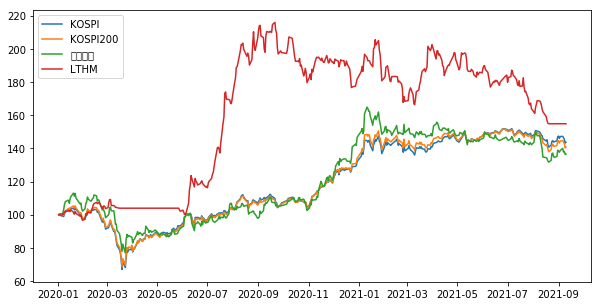

In [82]:
show_chart()

In [289]:
system.data.head()

,total,cash
2020-01-02,100000000.0,70077800.0
2020-01-03,99808300.0,70077800.0
2020-01-06,99787300.0,60132800.0
2020-01-07,100211600.0,60132800.0
2020-01-08,100315600.0,60132800.0


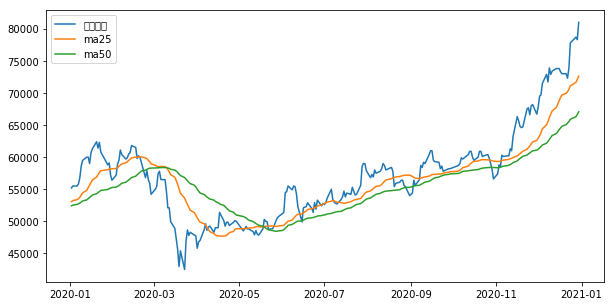

In [59]:
fig = plt.figure(figsize=(10,5))
fig.tight_layout()
subplot = fig.add_subplot(1,1,1)
    
code = "005930.KS"
ticker_data = ticker_dict[code]['data']
subplot.plot(ticker_data['Close'], label=ticker_dict[code]['stock_name'])
#subplot.plot(ticker_data['ma5'], label='ma5')
subplot.plot(ticker_data['ma25'], label='ma25')
subplot.plot(ticker_data['ma50'], label='ma50')
#subplot.plot(ticker_data['ma100'], label='ma100')
subplot.legend()
plt.show()